Hunter Bennett  
Christopher K Glass Laboratory  
Created 20180117 | Last updated 20180117
_____

Based on feedback from the bioinformatics team I am revamping my ATAC-Seq pipeline. Older vesions end with the 010318_ATAC_Diff_Peak.ipynb. For this we will be using the idr 2.0.3 release that should be a little easier to incorporate into the pipeline. General outline of the pipeline:
1. Call peaks on replicates with HOMER
2. Merge replicate peaks with HOMER
3. Annotate replicate peaks with HOMER
4. Use IDR to call peaks that have a sufficiently low IDR.
5. Select 'interesting' peaks by fold change cutoffs (IE FC > 2, FC > 4)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess
import os
import sys
import glob
import re

# import user defined packages
sys.path.insert(0, '/home/h1bennet/scripts')
import hbUtils

# plot matplotlib plots in notebook
%matplotlib inline

In [12]:
def compare_idr(idr_dir_1, idr_dir_2, outdir, dist='given'):
    """Takes two IDR folders, processes with homer, and compares their shared peaks
    Returns annotated and merged peak file. Second directory passed will be the denominator
    in the fold change comparison
    """
    idr_name_1 = idr_dir_1.split('/')[-1]
    idr_name_2 = idr_dir_2.split('/')[-1]
    appath = anno_peaks(idr_dir_1, idr_dir_2, outdir, dist='given', noann=True, nogene=True, norm='norm')
    df = pd.read_csv(appath, sep='\t') 
    # rename sample IDs
    df = df.rename(columns={df.columns.values[-2]:idr_name_1, df.columns.values[-1]:idr_name_2})
    # remove genes mapping to ChrM
    df = df.loc[df.Chr != 'chrM', :]
    # calculate log 2 counts
    df.loc[:, 'log2 ' + idr_name_1] = np.log2(df.loc[:, idr_name_1] + 1)
    df.loc[:, 'log2 ' + idr_name_2] = np.log2(df.loc[:, idr_name_2] + 1)
    # label columns and calculate fc, then bin fc
    df['fc'] = df.loc[:, idr_name_1] / df.loc[:, idr_name_2]
    df['log2_fc'] = np.log2(df['fc'])
    df.loc[df.log2_fc == -np.inf, 'log2_fc'] = 0
    df['fc_bin'] = pd.cut(np.abs(df['log2_fc']), [0, np.log2(2), np.log2(4), np.inf], labels=['all', '2', '4'])
    g = sns.lmplot(x='log2 ' + idr_name_2,
                   y='log2 ' + idr_name_1,
                   data=df, hue='fc_bin',
                   hue_order = ['all', '2', '4'],
                   fit_reg=False, size=10)
    return df
    
def merge_peaks(idr_dir_1, idr_dir_2, outdir, dist='given', print_err=False):
    # pull out idr sample names
    idr_name_1 = idr_dir_1.split('/')[-1]
    idr_name_2 = idr_dir_2.split('/')[-1]
    output_filepath = outdir + '/' + idr_name_1 + '_merge_' + idr_name_2 + '.txt'
    
    # construct function call
    mP_call = ["mergePeaks"]
    mP_call.extend(['-d', dist])
    mP_call.extend([idr_dir_1 + '/optimal_peakfile.txt',
                    idr_dir_2 + '/optimal_peakfile.txt'])
    
    # call merge peaks
    if not os.path.isfile(output_filepath):
        print('calling mergePeaks...')
        p = subprocess.Popen(mP_call,
                            stdout = subprocess.PIPE,
                            stderr = subprocess.PIPE)
        output, err = p.communicate() #in bytes
        if print_err: print(err.decode('utf-8'))
        f = open(output_filepath, 'w')
        f.write(output.decode("utf-8"))
        f.close()
    else: print('mergePeaks file ' + output_filepath + ' already exists!')
    return output_filepath

def anno_peaks(idr_dir_1, idr_dir_2, outdir, dist='given', noann=False, nogene=False, norm=False, print_err=False):
    # call merge peaks
    mPPath = merge_peaks(idr_dir_1=idr_dir_1, idr_dir_2=idr_dir_2, outdir=outdir, dist=dist, print_err=print_err)
    # construct function call
    aPCallList = ['annotatePeaks.pl', mPPath, 'mm10']
    if noann: aPCallList.extend(['-noann'])
    if nogene: aPCallList.extend(['-nogene'])
    if norm: aPCallList.extend(['-norm', '1e7'])
    aPCallList.extend(['-d', idr_dir_1 + '/pooled_tag_dirs', idr_dir_2 + '/pooled_tag_dirs'])
    if print_err: print(' '.join(aPCallList))
    # call annotate peaks
    aPPath = mPPath.replace('.txt', '_ann.txt')
    if not os.path.isfile(aPPath):
        print('calling annotatePeaks...')
        p = subprocess.Popen(aPCallList,
                         stdout=subprocess.PIPE,
                         stderr=subprocess.PIPE)
        output, err = p.communicate()
        if print_err: print(err.decode('utf-8'))
        #write output
        f = open(aPPath, 'w')
        f.write(output.decode("utf-8"))
        f.close()
    else: print('annotate peaks file: ' + aPPath + ' already exists!')
    return aPPath

In [5]:
# define path to data
datapath = {'kupffer':'/data/mm10/Kupffer/ATAC/'}

# define output directory
outdir = '/home/h1bennet/liverStrains/results/180111_ATAC/'

if not os.path.isdir(outdir):
    subprocess.call(['mkdir', '-p', outdir])

# define samples for both whole liver and kupffer
samples = {'kupffer':["aj_Kupffer_ATAC_AMLNDiet_30week_AJ3A_JSS_TDT_16_09_26",
"aj_Kupffer_ATAC_AMLNDiet_30week_AJ3B_JSS_TDT_16_09_26",
"aj_Kupffer_ATAC_ControlDiet_30week_AJ1B_JSS_TDT_16_09_26",
"aj_Kupffer_ATAC_ControlDiet_30week_AJ1C_JSS_TDT_16_09_28",
"balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3C_JSS_TDT_16_09_26",
"balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3D_JSS_TDT_16_09_28",
"balbc_Kupffer_ATAC_ControlDiet_30week_Balb1A_JSS_TDT_16_09_26",
"balbc_Kupffer_ATAC_ControlDiet_30week_Balb1B_JSS_TDT_16_09_26",
"NCoRWT_KupfferTotal_ATAC_AMLNDiet_30week_LN136C_JSS_TDT_16_09_19",
"NCoRWT_KupfferTotal_ATAC_AMLNDiet_30week_LN141A_JSS_TDT_16_09_21",
"NCoRWT_KupfferTotal_ATAC_ControlDiet_30week_LN134B_JSS_TDT_16_09_21",
"NCoRWT_KupfferTotal_ATAC_ControlDiet_30week_LN134D_JSS_TDT_16_09_21"]}

bad_samples = {'LN140D': 'cancer', 'LN136B': 'cancer', 'LN148B': 'cancer',
              'LN144A': 'cancer', 'LN144C': 'cancer', 'LN182B': 'cancer',
              'LN182B': 'cancer', 'LN203B': 'cancer', 'BALB3A': 'splenomegaly',
              'BALB4D': 'hyper-fibrosis', 'LN148B': 'cancer', 'LN166A': 'cancer'}

In [6]:
# define sample data frame
samplesDF = pd.DataFrame([s for groups in samples.values() for s in groups], columns = ['subject'])
samplesDF['sample_type'] = ['liver' if 'WholeLiver' in name else 'kupffer' for name in samplesDF.subject]
samplesDF['path'] = [datapath[key] + s for key in datapath.keys() for s in samples[key]]
samplesDF['batch'] = pd.factorize(samplesDF.subject\
             .str.replace('-','_')\
             .str.findall(r'(\d+_\d+_\d+)').str[0])[0]
samplesDF['strain'] = [j.replace('-', '_').split('_')[0].lower() for j in samplesDF.subject]
samplesDF['diet'] = ['amln' if 'AMLN' in name else 'control' for name in samplesDF.subject]
samplesDF['group'] = samplesDF.strain + '_' + samplesDF.diet
samplesDF['group_tissue'] = samplesDF.strain + '_' + samplesDF.diet + '_' + samplesDF.sample_type
samplesDF['exclusion'] = samplesDF.subject.str.contains('|'.join(bad_samples.keys()),
                                                       flags=re.IGNORECASE)

In [7]:
# set colors for the samples
color_dict = {'aj_control':'#fb9a99', 'aj_amln':'#e31a1c',
              'balbc_control':'#a6cee3', 'balbc_amln':'#1f78b4',
              'ncorwt_control':'#b2df8a', 'ncorwt_amln':'#33a02c'}
color_dict_tissue = {'aj_control_kupffer':'#fb9a99', 'aj_amln_kupffer':'#e31a1c',
            'balbc_control_kupffer':'#a6cee3', 'balbc_amln_kupffer':'#1f78b4',
            'ncorwt_control_kupffer':'#b2df8a', 'ncorwt_amln_kupffer':'#33a02c',
            'aj_control_liver':'#fdae6b', 'aj_amln_liver':'#e6550d',
            'balbc_control_liver':'#bcbddc', 'balbc_amln_liver':'#756bb1',
            'ncorwt_control_liver':'#bdbdbd', 'ncorwt_amln_liver':'#737373'}
samplesDF['color'] = [color_dict[group] for group in samplesDF.group]

# write out samplesDF
samplesDF.to_csv(outdir + 'amln_samples.txt', sep='\t')

In [8]:
for i in samplesDF.group.unique():
    analysis = i.replace('-', '_')
    print('analyzing ' + analysis)
    tmp = samplesDF[samplesDF.group == i]
    
    if not (os.path.isdir(outdir + analysis) & os.path.isfile(outdir + analysis + '/optimal_peakfile.txt')):
        #Run IDR with wrapper from Verena
        perlCallList = ['perl', '/home/h1bennet/liverStrains/bin/run_IDR.pl', '-tag_dirs']
        perlCallList.extend(tmp.path)
        perlCallList.extend(['-output_dir', outdir + analysis, '-method', 'atac'])
        subprocess.call(perlCallList)

analyzing aj_amln
analyzing aj_control
analyzing balbc_amln
analyzing balbc_control
analyzing ncorwt_amln
analyzing ncorwt_control


# Put Principal Component/Clustering Analysis Back into this Data

# Call differential peaks

In [9]:
sns.set_context('talk', font_scale=2)

mergePeaks file /home/h1bennet/liverStrains/results/180111_ATAC//ncorwt_amln_merge_ncorwt_control.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/180111_ATAC//ncorwt_amln_merge_ncorwt_control_ann.txt already exists!


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


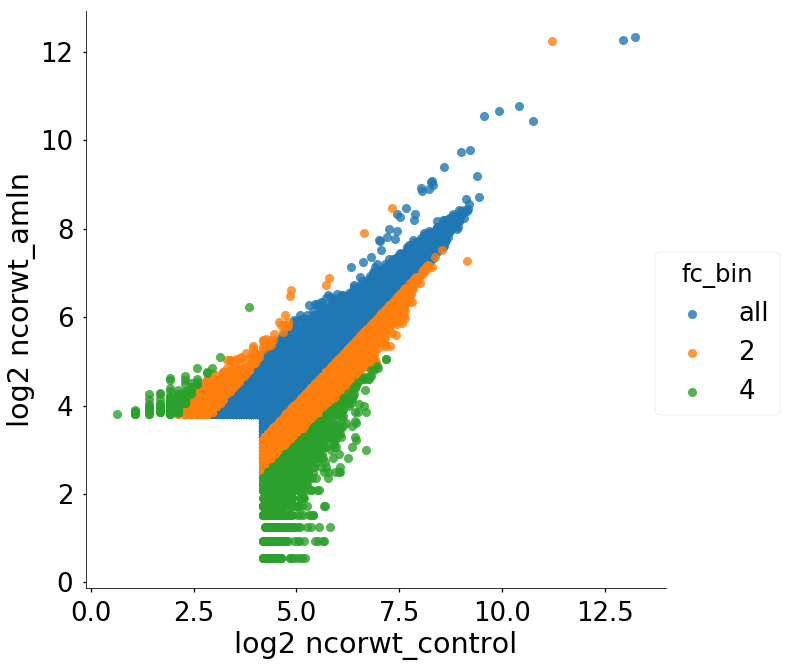

In [13]:
ncorwt_peaks = compare_idr(outdir + 'ncorwt_amln', outdir + 'ncorwt_control', outdir, dist='given')

In [16]:
ncorwt_peaks.loc[ncorwt_peaks.fc >= 2, :].to_csv(outdir + 'ncorwt_amln_diff_peaks_fc2_up.txt', sep='\t', index=False)
ncorwt_peaks.loc[ncorwt_peaks.fc >= 4, :].to_csv(outdir + 'ncorwt_amln_diff_peaks_fc4_up.txt', sep='\t', index=False)
ncorwt_peaks.loc[ncorwt_peaks.fc <= 1/2, :].to_csv(outdir + 'ncorwt_amln_diff_peaks_fc2_dn.txt', sep='\t', index=False)
ncorwt_peaks.loc[ncorwt_peaks.fc <= 1/4, :].to_csv(outdir + 'ncorwt_amln_diff_peaks_fc4_dn.txt', sep='\t', index=False)

In [21]:
ncorwt_peaks.loc[ncorwt_peaks.fc >= 2, :].shape
ncorwt_peaks.loc[ncorwt_peaks.fc >= 4, :].shape
ncorwt_peaks.loc[ncorwt_peaks.fc <= 1/2, :].shape
ncorwt_peaks.loc[ncorwt_peaks.fc <= 1/4, :].shape

(1837, 14)

mergePeaks file /home/h1bennet/liverStrains/results/180111_ATAC//balbc_amln_merge_balbc_control.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/180111_ATAC//balbc_amln_merge_balbc_control_ann.txt already exists!


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


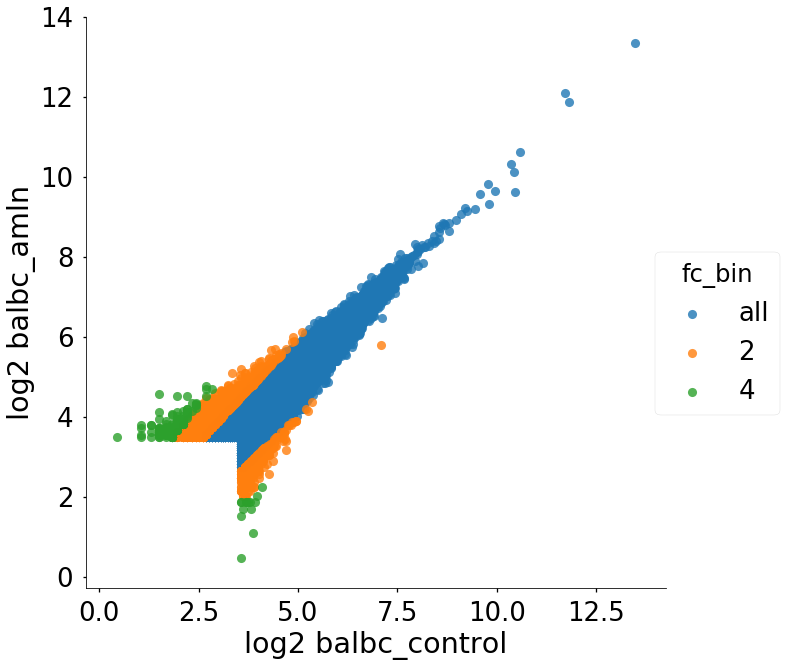

In [14]:
balbc_peaks = compare_idr(outdir + 'balbc_amln', outdir + 'balbc_control', outdir, dist='given')

In [11]:
balbc_peaks.loc[balbc_peaks.fc >= 2, :].to_csv(outdir + 'balbc_amln_diff_peaks_fc2_up.txt', sep='\t', index=False)
balbc_peaks.loc[balbc_peaks.fc >= 4, :].to_csv(outdir + 'balbc_amln_diff_peaks_fc4_up.txt', sep='\t', index=False)
balbc_peaks.loc[balbc_peaks.fc <= 1/2, :].to_csv(outdir + 'balbc_amln_diff_peaks_fc2_dn.txt', sep='\t', index=False)
balbc_peaks.loc[balbc_peaks.fc <= 1/4, :].to_csv(outdir + 'balbc_amln_diff_peaks_fc4_dn.txt', sep='\t', index=False)

In [22]:
print(balbc_peaks.loc[balbc_peaks.fc >= 2, :].shape)
print(balbc_peaks.loc[balbc_peaks.fc >= 4, :].shape)
print(balbc_peaks.loc[balbc_peaks.fc <= 1/2, :].shape)
print(balbc_peaks.loc[balbc_peaks.fc <= 1/4, :].shape)

(2808, 14)
(155, 14)
(396, 14)
(15, 14)


mergePeaks file /home/h1bennet/liverStrains/results/180111_ATAC//aj_amln_merge_aj_control.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/180111_ATAC//aj_amln_merge_aj_control_ann.txt already exists!


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


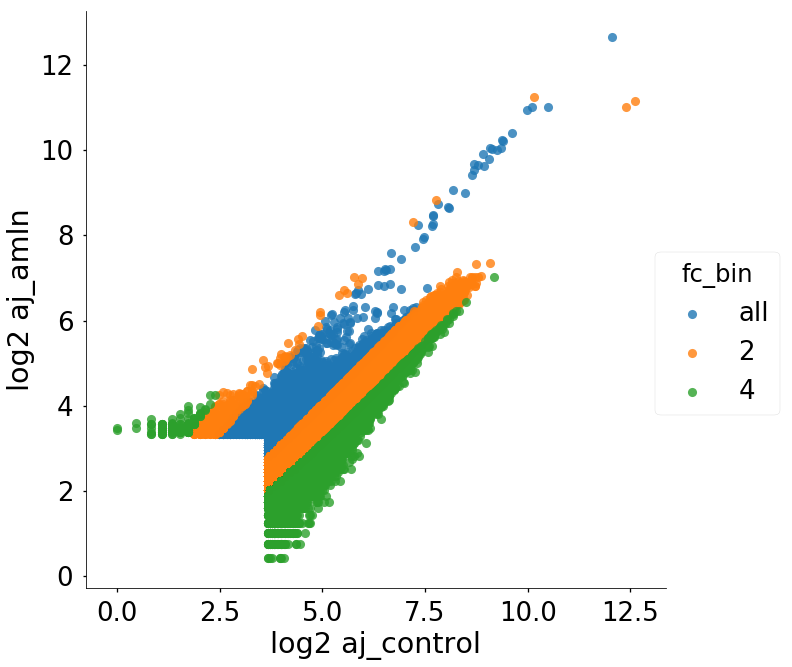

In [15]:
aj_peaks = compare_idr(outdir + 'aj_amln', outdir + 'aj_control', outdir, dist='given')

In [13]:
aj_peaks.loc[aj_peaks.fc >= 2, :].to_csv(outdir + 'aj_amln_diff_peaks_fc2_up.txt', sep='\t', index=False)
aj_peaks.loc[aj_peaks.fc >= 4, :].to_csv(outdir + 'aj_amln_diff_peaks_fc4_up.txt', sep='\t', index=False)
aj_peaks.loc[aj_peaks.fc <= 1/2, :].to_csv(outdir + 'aj_amln_diff_peaks_fc2_dn.txt', sep='\t', index=False)
aj_peaks.loc[aj_peaks.fc <= 1/4, :].to_csv(outdir + 'aj_amln_diff_peaks_fc4_dn.txt', sep='\t', index=False)

In [23]:
print(aj_peaks.loc[aj_peaks.fc >= 2, :].shape)
print(aj_peaks.loc[aj_peaks.fc >= 4, :].shape)
print(aj_peaks.loc[aj_peaks.fc <= 1/2, :].shape)
print(aj_peaks.loc[aj_peaks.fc <= 1/4, :].shape)

(518, 14)
(109, 14)
(46413, 14)
(8905, 14)


mergePeaks file /home/h1bennet/liverStrains/results/180111_ATAC//aj_control_merge_ncorwt_control.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/180111_ATAC//aj_control_merge_ncorwt_control_ann.txt already exists!


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


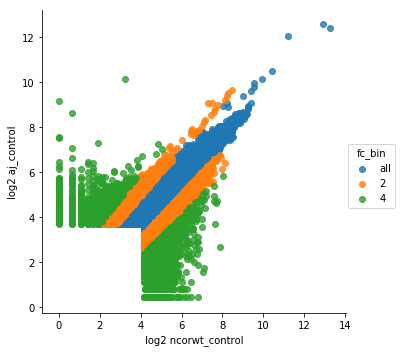

In [14]:
aj_ncorwt_control = compare_idr(outdir + 'aj_control', outdir + 'ncorwt_control', outdir, dist='given')

mergePeaks file /home/h1bennet/liverStrains/results/180111_ATAC//balbc_control_merge_ncorwt_control.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/180111_ATAC//balbc_control_merge_ncorwt_control_ann.txt already exists!


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


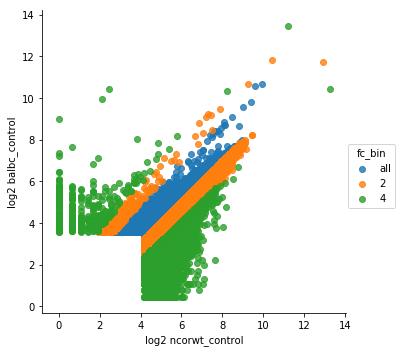

In [15]:
balbc_ncorwt_control = compare_idr(outdir + 'balbc_control', outdir + 'ncorwt_control', outdir, dist='given')

mergePeaks file /home/h1bennet/liverStrains/results/180111_ATAC//aj_control_merge_balbc_control.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/180111_ATAC//aj_control_merge_balbc_control_ann.txt already exists!


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


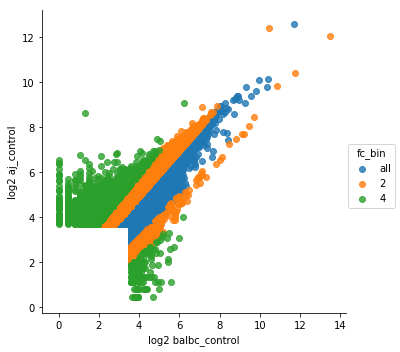

In [16]:
aj_balbc_control = compare_idr(outdir + 'aj_control', outdir + 'balbc_control', outdir, dist='given')

mergePeaks file /home/h1bennet/liverStrains/results/180111_ATAC//aj_amln_merge_ncorwt_amln.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/180111_ATAC//aj_amln_merge_ncorwt_amln_ann.txt already exists!


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


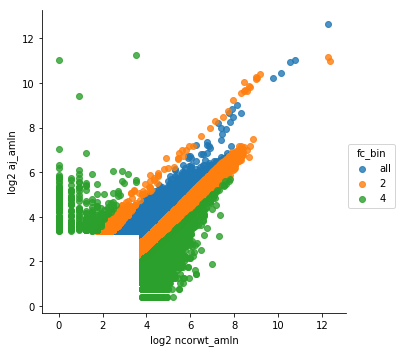

In [17]:
aj_ncorwt_amln = compare_idr(outdir + 'aj_amln', outdir + 'ncorwt_amln', outdir, dist='given')

mergePeaks file /home/h1bennet/liverStrains/results/180111_ATAC//balbc_amln_merge_ncorwt_amln.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/180111_ATAC//balbc_amln_merge_ncorwt_amln_ann.txt already exists!


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


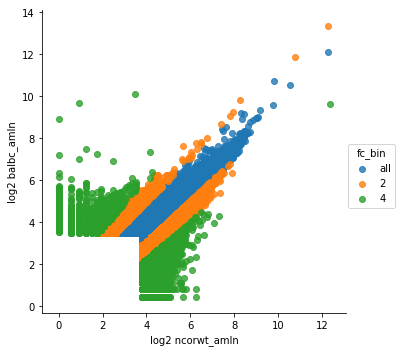

In [18]:
balbc_ncorwt_amln = compare_idr(outdir + 'balbc_amln', outdir + 'ncorwt_amln', outdir, dist='given')

mergePeaks file /home/h1bennet/liverStrains/results/180111_ATAC//aj_amln_merge_balbc_amln.txt already exists!
annotate peaks file: /home/h1bennet/liverStrains/results/180111_ATAC//aj_amln_merge_balbc_amln_ann.txt already exists!


/home/h1bennet/anaconda3/envs/atac/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2


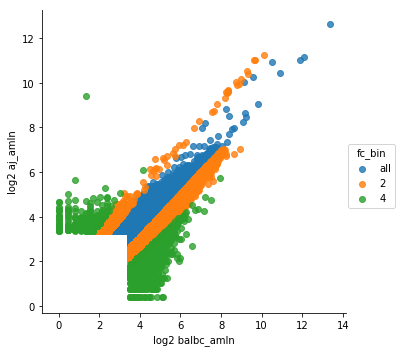

In [19]:
aj_balbc_amln = compare_idr(outdir + 'aj_amln', outdir + 'balbc_amln', outdir, dist='given')

# Next we will run the peak files through a MARGE analysis using Verena's script

## NCORWT

### All Peaks 

In [22]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'ncorwt_amln/optimal_peakfile.txt'} mm10 {outdir + 'motifs_peaks_ncorwt_amln_kupffer_atac'} -fg_ind c57bl6j


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/ncorwt_amln/optimal_peakfile.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_ncorwt_amln_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//C57BL6J/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 45551

	Peak File Statistics:
		Total Peaks: 45551
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for C57BL6J for 200 bp fragments found.
Saving peaks
Loading shift vectors
Skip peaks for chromosome Y allele 1 in get_seq_for_peaks
Can't open /home/vlink/mouse_strains/marge/db_part/strain

		103 of 364 (1e-82) NRF(NRF)/Promoter/Homer
		104 of 364 (1e-82) Mef2a(MADS)/HL1-Mef2a.biotin-ChIP-Seq(GSE21529)/Homer
		105 of 364 (1e-73) Mef2b(MADS)/HEK293-Mef2b.V5-ChIP-Seq(GSE67450)/Homer
		106 of 364 (1e-72) ETS:E-box(ETS,bHLH)/HPC7-Scl-ChIP-Seq(GSE22178)/Homer
		107 of 364 (1e-71) COUP-TFII(NR)/Artia-Nr2f2-ChIP-Seq(GSE46497)/Homer
		108 of 364 (1e-68) NPAS2(bHLH)/Liver-NPAS2-ChIP-Seq(GSE39860)/Homer
		109 of 364 (1e-64) MafF(bZIP)/HepG2-MafF-ChIP-Seq(GSE31477)/Homer
		110 of 364 (1e-63) CTCF-SatelliteElement(Zf?)/CD4+-CTCF-ChIP-Seq(Barski_et_al.)/Homer
		111 of 364 (1e-61) X-box(HTH)/NPC-H3K4me1-ChIP-Seq(GSE16256)/Homer
		112 of 364 (1e-58) Egr1(Zf)/K562-Egr1-ChIP-Seq(GSE32465)/Homer
		113 of 364 (1e-51) ZNF467(Zf)/HEK293-ZNF467.GFP-ChIP-Seq(GSE58341)/Homer
		114 of 364 (1e-51) GFX(?)/Promoter/Homer
		115 of 364 (1e-51) Rfx1(HTH)/NPC-H3K4me1-ChIP-Seq(GSE16256)/Homer
		116 of 364 (1e-48) Rfx5(HTH)/GM12878-Rfx5-ChIP-Seq(GSE31477)/Homer
		117 of 364 (1e-42) NFkB-p50,p52(RHD)/Monoc

	----------------------------------------------------------
	De novo motif finding (HOMER)

	Scanning input files...
	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 32896
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 32896 of 34497 max
	Tree  : 67104 of 172485 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos with up to 2 mismatches...

	Screening oligos 32896 (allowing 0 mismatches):
	|0%                                   50%                                  100%|
		0.00% skipped, 100.00% checked (32896 of 32896), of those checked:
		0.00% not in target, 0.00% increased p-value, 0.00% high p-value

	Screening oligos 32896 (allowing 1 mismatches):
	|0%                                   50%                                  100%|
		0.00% skipped, 100.00% checked (32896 of 32896), of those checked:
		0.

		Round 2: -211.22 CTCCACCC T:7069.0(14.41%),B:5313.4(11.28%),P:1e-91
		=Final=: -250.60 CTCCACCC T:8436.0(18.57%),B:6552.9(14.76%),P:1e-108
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	19 of 25 Initial Sequence: CCTAGTGG... (-134.415)
		Round 1: -253.57 MCTAGTGG T:2606.0(5.58%),B:1577.7(3.49%),P:1e-110
		Round 2: -253.57 MCTAGTGG T:2606.0(5.58%),B:1577.7(3.49%),P:1e-110
		=Final=: -202.67 MCTAGTGG T:2398.0(5.28%),B:1529.2(3.44%),P:1e-88
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	20 of 25 Initial Sequence: TCTCGCGA... (-128.453)
		Round 1: -159.39 TCTCGCGA T:552.0(1.21%),B:228.3(0.51%),P:1e-69
		Round 2: -159.39 TCTCGCGA T:552.0(1.21%),B:228.3(0.51%),P:1e-69
		=Final=: -82.87 TCTCGCGA T:399.0(0.88%),B:193.4(0.44%),P:1e-35
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	21 of 25 Initial Sequence: TGAATCAT... (-119.693)
		Round 1: -390.68 TGASTCAT T:1787.0(3.86%),B:828.6(1.85%),P

		=Final=: -2410.89 DVAGGAAGTR T:18438.0(40.59%),B:11395.8(25.66%),P:1e-1047
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	9 of 25 Initial Sequence: GTCACATGAC... (-357.448)
		Round 1: -540.90 GTCACATGAC T:1821.0(3.93%),B:731.6(1.63%),P:1e-234
		Round 2: -656.60 GTCACATGRC T:3681.0(7.78%),B:1831.9(4.04%),P:1e-285
		Round 3: -695.25 GTCACATGRC T:3701.0(7.82%),B:1805.6(3.98%),P:1e-301
		Round 4: -717.55 GTCACATGRC T:4602.0(9.63%),B:2394.8(5.25%),P:1e-311
		Round 5: -717.55 GTCACATGRC T:4602.0(9.63%),B:2394.8(5.25%),P:1e-311
		=Final=: -728.62 GTCACATGRC T:4354.0(9.59%),B:2302.8(5.19%),P:1e-316
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	10 of 25 Initial Sequence: TCTGATTGGC... (-314.125)
		Round 1: -919.67 TCTGATTGGC T:4250.0(8.93%),B:1951.9(4.30%),P:1e-399
		Round 2: -1134.08 TSYGATTGGC T:5882.0(12.15%),B:2809.8(6.13%),P:1e-492
		Round 3: -1134.08 TSYGATTGGC T:5882.0(12.15%),B:2809.8(6.13%),P:1e-492
		=Final=: -74

		=Final=: -354.98 RGCCCCRCCC T:5083.0(11.19%),B:3408.6(7.68%),P:1e-154
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...

	Finalizing Enrichment Statistics (new in v3.4)
	Reading input files...
	90850 total sequences read
	Cache length = 11180
	Using binomial scoring
	Checking enrichment of 25 motif(s)
	|0%                                    50%                                  100%|
	Output in file: /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_ncorwt_amln_kupffer_atac/homerMotifs.motifs10


	-blen automatically set to 2
	Scanning input files...
	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 5211527
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 5211527 of 8830118 max
	Tree  : 11463524 of 44150590 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos with u

		Round 2: -631.23 GGGAAATCCCCA T:2527.0(5.41%),B:1099.8(2.44%),P:1e-274
		Round 3: -691.57 GGGAAATCCCCN T:2563.0(5.49%),B:1074.3(2.39%),P:1e-300
		Round 4: -691.57 GGGAAATCCCCN T:2563.0(5.49%),B:1074.3(2.39%),P:1e-300
		=Final=: -413.05 GGGAAATCCCCN T:1038.0(2.29%),B:361.7(0.81%),P:1e-179
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	14 of 25 Initial Sequence: TATTGCACAATA... (-193.435)
		Round 1: -564.72 TATTGCACAATA T:1315.0(2.85%),B:429.4(0.96%),P:1e-245
		Round 2: -804.18 TATTGCACAATA T:4259.0(8.95%),B:2067.8(4.55%),P:1e-349
		Round 3: -888.16 BMTTKCACAABH T:6114.0(12.59%),B:3239.5(7.03%),P:1e-385
		Round 4: -888.16 BMTTKCACAABH T:6114.0(12.59%),B:3239.5(7.03%),P:1e-385
		=Final=: -817.31 BMTTKCACAABH T:5644.0(12.42%),B:3150.6(7.09%),P:1e-354
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	15 of 25 Initial Sequence: TTTTTTTTTTTT... (-167.082)
		Round 1: -182.19 TTTTTTTTTTTT T:4129.0(8.69%),B:2941.0(6.41%),P:1e-7

In [23]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'ncorwt_control/optimal_peakfile.txt'} mm10 {outdir + 'motifs_peaks_ncorwt_control_kupffer_atac'} -fg_ind c57bl6j


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/ncorwt_control/optimal_peakfile.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_ncorwt_control_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//C57BL6J/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 51142

	Peak File Statistics:
		Total Peaks: 51142
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for C57BL6J for 200 bp fragments found.
Saving peaks
Loading shift vectors
Skip peaks for chromosome Y allele 1 in get_seq_for_peaks
Can't open /home/vlink/mouse_strains/marge/db_part/

		106 of 364 (1e-80) n-Myc(bHLH)/mES-nMyc-ChIP-Seq(GSE11431)/Homer
		107 of 364 (1e-74) ETS:E-box(ETS,bHLH)/HPC7-Scl-ChIP-Seq(GSE22178)/Homer
		108 of 364 (1e-73) NRF(NRF)/Promoter/Homer
		109 of 364 (1e-69) ZNF467(Zf)/HEK293-ZNF467.GFP-ChIP-Seq(GSE58341)/Homer
		110 of 364 (1e-58) Nur77(NR)/K562-NR4A1-ChIP-Seq(GSE31363)/Homer
		111 of 364 (1e-58) Pknox1(Homeobox)/ES-Prep1-ChIP-Seq(GSE63282)/Homer
		112 of 364 (1e-57) NPAS2(bHLH)/Liver-NPAS2-ChIP-Seq(GSE39860)/Homer
		113 of 364 (1e-56) X-box(HTH)/NPC-H3K4me1-ChIP-Seq(GSE16256)/Homer
		114 of 364 (1e-52) GFX(?)/Promoter/Homer
		115 of 364 (1e-51) Rfx1(HTH)/NPC-H3K4me1-ChIP-Seq(GSE16256)/Homer
		116 of 364 (1e-50) Egr2(Zf)/Thymocytes-Egr2-ChIP-Seq(GSE34254)/Homer
		117 of 364 (1e-47) NFkB-p50,p52(RHD)/Monocyte-p50-ChIP-Chip(Schreiber_et_al.)/Homer
		118 of 364 (1e-47) Meis1(Homeobox)/MastCells-Meis1-ChIP-Seq(GSE48085)/Homer
		119 of 364 (1e-46) Egr1(Zf)/K562-Egr1-ChIP-Seq(GSE32465)/Homer
		120 of 364 (1e-45) CTCF-SatelliteElement(Zf?)/C

	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 32896
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 32896 of 34497 max
	Tree  : 67016 of 172485 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos with up to 2 mismatches...

	Screening oligos 32896 (allowing 0 mismatches):
	|0%                                   50%                                  100%|
		0.00% skipped, 100.00% checked (32896 of 32896), of those checked:
		0.00% not in target, 0.00% increased p-value, 0.00% high p-value

	Screening oligos 32896 (allowing 1 mismatches):
	|0%                                   50%                                  100%|
		0.00% skipped, 100.00% checked (32896 of 32896), of those checked:
		0.00% not in target, 53.42% increased p-value, 45.95% high p-value

	Screening oligos 32896 (allowing 2 mismatches):
	|

		Round 2: -173.44 TGACGTCA T:2913.0(5.55%),B:1967.6(3.87%),P:1e-75
		=Final=: -166.89 TGACGTCA T:2800.0(5.48%),B:1917.2(3.85%),P:1e-72
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	19 of 25 Initial Sequence: TGCTGACT... (-100.982)
		Round 1: -245.66 TGHTGACT T:7712.0(14.02%),B:5729.8(10.87%),P:1e-106
		Round 2: -254.51 TKATGACG T:9846.0(17.54%),B:7501.1(13.99%),P:1e-110
		Round 3: -268.49 TGATGACR T:4724.0(8.84%),B:3203.8(6.23%),P:1e-116
		Round 4: -268.49 TGATGACR T:4724.0(8.84%),B:3203.8(6.23%),P:1e-116
		=Final=: -250.30 TGATGACR T:4451.0(8.72%),B:3092.4(6.21%),P:1e-108
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	20 of 25 Initial Sequence: CTCCACCC... (-96.045)
		Round 1: -195.40 CTCCACCC T:7550.0(13.75%),B:5771.1(10.95%),P:1e-84
		Round 2: -195.40 CTCCACCC T:7550.0(13.75%),B:5771.1(10.95%),P:1e-84
		=Final=: -220.59 CTCCACCC T:6384.0(12.50%),B:4814.6(9.67%),P:1e-95
		Performing exhaustive masking of motif...

		=Final=: -1342.75 CCCCCTAGTG T:2276.0(4.46%),B:602.1(1.21%),P:1e-583
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	8 of 25 Initial Sequence: GTCACATGAC... (-446.470)
		Round 1: -806.13 GTCACATGAC T:2613.0(4.99%),B:1022.8(2.03%),P:1e-350
		Round 2: -890.27 GTCACATGAC T:2684.0(5.12%),B:1009.8(2.01%),P:1e-386
		Round 3: -983.27 GTCACATGAY T:3782.0(7.14%),B:1601.7(3.17%),P:1e-427
		Round 4: -983.27 GTCACATGAY T:3782.0(7.14%),B:1601.7(3.17%),P:1e-427
		=Final=: -972.31 GTCACATGAY T:3573.0(7.00%),B:1537.7(3.09%),P:1e-422
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	9 of 25 Initial Sequence: CGCATGCGCA... (-428.213)
		Round 1: -539.30 CGCATGCGCA T:4924.0(9.19%),B:2858.9(5.58%),P:1e-234
		Round 2: -553.77 CGCATGCGCA T:3740.0(7.06%),B:1986.1(3.91%),P:1e-240
		Round 3: -561.15 CGCATGCGCA T:3331.0(6.32%),B:1693.1(3.34%),P:1e-243
		Round 4: -584.14 CGCWTGCGYA T:2815.0(5.36%),B:1324.0(2.62%),P:1e-253
		Round 5: -584.14 CGCWT

		Reprioritizing potential motifs...
	24 of 25 Initial Sequence: AGGTGGCGCT... (-76.073)
		Round 1: -103.04 AGGTGGCGCT T:294.0(0.57%),B:111.5(0.22%),P:1e-44
		Round 2: -104.28 AGGGGGCGAT T:297.0(0.58%),B:113.0(0.22%),P:1e-45
		Round 3: -113.74 AGAGGGCGCT T:690.0(1.34%),B:360.3(0.72%),P:1e-49
		Round 4: -149.04 AGAGGGCGST T:1916.0(3.68%),B:1226.0(2.43%),P:1e-64
		Round 5: -175.04 AGAGGGCGST T:1287.0(2.49%),B:711.9(1.42%),P:1e-76
		Round 6: -179.87 AGRGGGCGGT T:1194.0(2.31%),B:639.8(1.28%),P:1e-78
		Round 7: -179.87 AGRGGGCGGT T:1194.0(2.31%),B:639.8(1.28%),P:1e-78
		=Final=: -183.05 AGRGGGCGGT T:1174.0(2.30%),B:626.4(1.26%),P:1e-79
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	25 of 25 Initial Sequence: CGAAACCACA... (-70.081)
		Round 1: -128.39 CGAAACCACA T:2024.0(3.89%),B:1354.6(2.68%),P:1e-55
		Round 2: -128.39 CGAAACCACA T:2024.0(3.89%),B:1354.6(2.68%),P:1e-55
		=Final=: -128.09 CGAAACCACA T:1977.0(3.87%),B:1330.9(2.67%),P:1e-55
		Performing exhau

		Reprioritizing potential motifs...
	11 of 25 Initial Sequence: CGGCCAATCAGA... (-355.730)
		Round 1: -936.56 CGGCCAATCAGA T:3816.0(7.20%),B:1659.7(3.28%),P:1e-406
		Round 2: -1293.00 CRGCCAATCAGA T:4513.0(8.46%),B:1814.6(3.58%),P:1e-561
		Round 3: -1345.98 CAGCCAATSRGA T:5261.0(9.79%),B:2228.9(4.38%),P:1e-584
		Round 4: -1427.09 BRRCCAATSRGV T:4089.0(7.70%),B:1480.7(2.93%),P:1e-619
		Round 5: -1427.09 BRRCCAATSRGV T:4089.0(7.70%),B:1480.7(2.93%),P:1e-619
		=Final=: -1057.60 BRRCCAATSRGV T:3139.0(6.15%),B:1209.9(2.43%),P:1e-459
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	12 of 25 Initial Sequence: AACCGGAAGTGG... (-251.865)
		Round 1: -517.09 AACCGGAAGTGG T:2178.0(4.18%),B:970.9(1.93%),P:1e-224
		Round 2: -729.03 AACMGGAAGTGG T:9797.0(17.46%),B:6197.9(11.71%),P:1e-316
		Round 3: -729.03 AACMGGAAGTGG T:9797.0(17.46%),B:6197.9(11.71%),P:1e-316
		=Final=: -722.41 AACMGGAAGTGG T:7992.0(15.65%),B:5089.7(10.22%),P:1e-313
		Performing exhaustive masking 

### FC cut off peaks

In [24]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'ncorwt_amln_diff_peaks_fc2_up.txt'} mm10 {outdir + 'motifs_peaks_ncorwt_amln_fc2_up_kupffer_atac'} -fg_ind c57bl6j


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/ncorwt_amln_diff_peaks_fc2_up.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_ncorwt_amln_fc2_up_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//C57BL6J/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 1100

	Peak File Statistics:
		Total Peaks: 1100
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for C57BL6J for 200 bp fragments found.
Saving peaks
Loading shift vectors
Skip peaks for chromosome Y allele 1 in get_seq_for_peaks
Can't open /home/vlink/mouse_strains/marge/db_part/

		76 of 364 (1e-4) Tbx5(T-box)/HL1-Tbx5.biotin-ChIP-Seq(GSE21529)/Homer
		77 of 364 (1e-4) NFAT:AP1(RHD,bZIP)/Jurkat-NFATC1-ChIP-Seq(Jolma_et_al.)/Homer
		78 of 364 (1e-4) IRF1(IRF)/PBMC-IRF1-ChIP-Seq(GSE43036)/Homer
		79 of 364 (1e-4) Foxa2(Forkhead)/Liver-Foxa2-ChIP-Seq(GSE25694)/Homer
		80 of 364 (1e-4) Egr1(Zf)/K562-Egr1-ChIP-Seq(GSE32465)/Homer
		81 of 364 (1e-4) USF1(bHLH)/GM12878-Usf1-ChIP-Seq(GSE32465)/Homer
		82 of 364 (1e-4) PU.1:IRF8(ETS:IRF)/pDC-Irf8-ChIP-Seq(GSE66899)/Homer
		83 of 364 (1e-4) GATA3(Zf)/iTreg-Gata3-ChIP-Seq(GSE20898)/Homer
		84 of 364 (1e-4) FOXK1(Forkhead)/HEK293-FOXK1-ChIP-Seq(GSE51673)/Homer
		85 of 364 (1e-4) FoxL2(Forkhead)/Ovary-FoxL2-ChIP-Seq(GSE60858)/Homer
		86 of 364 (1e-4) Klf4(Zf)/mES-Klf4-ChIP-Seq(GSE11431)/Homer
		87 of 364 (1e-4) Gata4(Zf)/Heart-Gata4-ChIP-Seq(GSE35151)/Homer
		88 of 364 (1e-4) Atf4(bZIP)/MEF-Atf4-ChIP-Seq(GSE35681)/Homer
		89 of 364 (1e-4) ISRE(IRF)/ThioMac-LPS-Expression(GSE23622)/Homer
		90 of 364 (1e-4) Foxo3(Forkhead)/U2

		=Final=: -50.49 TGACGTSA T:121.0(11.12%),B:2059.4(4.08%),P:1e-21
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	6 of 25 Initial Sequence: GAAAATCA... (-32.626)
		Round 1: -42.65 GAAAATCA T:60.0(5.37%),B:606.2(1.27%),P:1e-18
		Round 2: -47.87 RRAAATGA T:122.0(10.61%),B:1878.5(3.88%),P:1e-20
		Round 3: -47.87 RRAAATGA T:122.0(10.61%),B:1878.5(3.88%),P:1e-20
		=Final=: -15.93 RRAAATGA T:75.0(6.89%),B:1815.5(3.60%),P:1e-6
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	7 of 25 Initial Sequence: AAACCACA... (-27.922)
		Round 1: -38.06 AAACCACA T:73.0(6.49%),B:945.4(1.97%),P:1e-16
		Round 2: -38.06 AAACCACA T:73.0(6.49%),B:945.4(1.97%),P:1e-16
		=Final=: -42.96 AAACCACA T:89.0(8.18%),B:1375.6(2.72%),P:1e-18
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	8 of 25 Initial Sequence: GCCATATT... (-23.579)
		Round 1: -24.66 GCCATATT T:25.0(2.27%),B:183.8(0.38%),P:1e-10
		Round 2: -24.70 GCCACA

		Round 1: -94.24 CACTAGGGGG T:116.0(10.12%),B:987.4(2.06%),P:1e-40
		Round 2: -94.24 CACTAGGGGG T:116.0(10.12%),B:987.4(2.06%),P:1e-40
		=Final=: -93.88 CACTAGGGGG T:103.0(9.47%),B:909.6(1.80%),P:1e-40
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	6 of 25 Initial Sequence: TCGCCATATT... (-40.614)
		Round 1: -72.18 TCGCCATATT T:21.0(1.91%),B:12.0(0.02%),P:1e-31
		Round 2: -72.18 TCGCCATATT T:21.0(1.91%),B:12.0(0.02%),P:1e-31
		=Final=: -32.60 TCGCCATATT T:8.0(0.74%),B:3.6(0.01%),P:1e-14
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	7 of 25 Initial Sequence: TTCTCATTTT... (-39.573)
		Round 1: -48.96 TTCTCATTTT T:23.0(2.09%),B:46.7(0.10%),P:1e-21
		Round 2: -48.96 TTCTCATTTT T:23.0(2.09%),B:46.7(0.10%),P:1e-21
		=Final=: -23.64 TTCTCATTTT T:13.0(1.19%),B:46.7(0.09%),P:1e-10
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	8 of 25 Initial Sequence: TGTGGTTAAC... (-39.062)
		Round 1: -7

	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 3943831
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 3943831 of 8830118 max
	Tree  : 8982424 of 44150590 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos with up to 2 mismatches...

	Screening oligos 3943831 (allowing 0 mismatches):
	|0%                                   50%                                  100%|
		95.11% skipped, 4.89% checked (192817 of 3943831), of those checked:
		95.11% not in target, 0.00% increased p-value, 0.00% high p-value

	Screening oligos 3943831 (allowing 1 mismatches):
	|0%                                   50%                                  100%|
		95.11% skipped, 4.89% checked (192817 of 3943831), of those checked:
		0.00% not in target, 4.51% increased p-value, 0.12% high p-value

	Screening oligos 3943831 (allowin

		Round 2: -23.69 ATGTTTCTCATT T:6.0(0.55%),B:3.0(0.00%),P:1e-10
		=Final=: -20.55 ATGTTTCTCATT T:5.0(0.46%),B:3.0(0.01%),P:1e-8
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	17 of 25 Initial Sequence: CTTGAAAAATGA... (-18.303)
		Round 1: -25.12 CTTGAAAAATGA T:7.0(0.64%),B:3.2(0.01%),P:1e-10
		Round 2: -25.12 CTTGAAAAATGA T:7.0(0.64%),B:3.2(0.01%),P:1e-10
		=Final=: -29.64 CTTGAAAAATGA T:6.0(0.55%),B:0.0(0.00%),P:1e-12
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	18 of 25 Initial Sequence: GCTGGCCTGGGC... (-17.705)
		Round 1: -19.77 GCTGGCCTGGGC T:8.0(0.73%),B:10.4(0.02%),P:1e-8
		Round 2: -19.77 GCTGGCCTGGGC T:8.0(0.73%),B:10.4(0.02%),P:1e-8
		=Final=: -12.65 GCTGGCCTGGGC T:5.0(0.46%),B:10.4(0.02%),P:1e-5
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	19 of 25 Initial Sequence: CACAGGGGAGGG... (-15.720)
		Round 1: -17.71 CACAGGGGAGGG T:7.0(0.64%),B:8.7(0.02%),P:1e-7
		Round 2: -

In [25]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'ncorwt_amln_diff_peaks_fc4_up.txt'} mm10 {outdir + 'motifs_peaks_ncorwt_amln_fc4_up_kupffer_atac'} -fg_ind c57bl6j


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/ncorwt_amln_diff_peaks_fc4_up.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_ncorwt_amln_fc4_up_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//C57BL6J/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 164

	Peak File Statistics:
		Total Peaks: 164
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for C57BL6J for 200 bp fragments found.
Saving peaks
Loading shift vectors

	Not removing redundant sequences


	Sequences processed:
		Auto detected maximum sequence length of 200 bp
		

		50.89% skipped, 49.11% checked (16155 of 32896), of those checked:
		0.00% not in target, 24.13% increased p-value, 31.61% high p-value

	Screening oligos 32896 (allowing 2 mismatches):
	|0%                                   50%                                  100%|
		87.89% skipped, 12.11% checked (3985 of 32896), of those checked:
		0.00% not in target, 10.78% increased p-value, 0.00% high p-value
	Reading input files...
	53042 total sequences read
	Cache length = 11180
	Using binomial scoring

	Local Optimization Phase:
	1 of 25 Initial Sequence: TGAGTCAT... (-45.451)
		Round 1: -98.47 TGAGTCAT T:108.0(48.34%),B:3831.0(7.70%),P:1e-42
		Round 2: -98.47 TGAGTCAT T:108.0(48.34%),B:3831.0(7.70%),P:1e-42
		=Final=: -67.01 TGAGTCAT T:57.0(34.76%),B:2854.1(5.62%),P:1e-29
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	2 of 25 Initial Sequence: TAGGATGT... (-24.366)
		Round 1: -43.62 TAGGAYGT T:43.0(23.13%),B:1695.4(3.48%),P:1e-18
		Round 2: -44.90 TAGGA

		Round 2: -28.85 TTGTCATTTT T:18.0(10.42%),B:436.1(0.91%),P:1e-12
		=Final=: -17.56 TTGTCATTTT T:12.0(7.32%),B:434.5(0.85%),P:1e-7
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	7 of 25 Initial Sequence: TGTGATATCA... (-13.815)
		Round 1: -28.38 TGTGATATCA T:40.0(21.70%),B:2490.1(5.08%),P:1e-12
		Round 2: -29.23 HGTGATATCA T:38.0(20.74%),B:2272.7(4.64%),P:1e-12
		Round 3: -29.23 HGTGATATCA T:38.0(20.74%),B:2272.7(4.64%),P:1e-12
		=Final=: -21.35 HGTGATATCA T:27.0(16.46%),B:2038.9(4.01%),P:1e-9
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	8 of 25 Initial Sequence: AGTTGTGGTT... (-13.734)
		Round 1: -24.21 AGTTGTGGTT T:14.0(8.21%),B:286.0(0.59%),P:1e-10
		Round 2: -24.21 AGTTGTGGTT T:14.0(8.21%),B:286.0(0.59%),P:1e-10
		=Final=: -27.72 AGTTGTGGTT T:14.0(8.54%),B:286.0(0.56%),P:1e-12
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	9 of 25 Initial Sequence: GTGAGTCAGG... (-12.051)
		R

		Reprioritizing potential motifs...
	4 of 25 Initial Sequence: GTCCTACAGTGT... (-21.137)
		Round 1: -38.68 GTCCTACAGTGT T:8.0(4.78%),B:5.9(0.01%),P:1e-16
		Round 2: -38.68 GTCCTACAGTGT T:8.0(4.78%),B:5.9(0.01%),P:1e-16
		=Final=: -19.74 GTCCTACAGTGT T:4.0(2.44%),B:5.9(0.01%),P:1e-8
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	5 of 25 Initial Sequence: GAAAATGAGAAA... (-20.379)
		Round 1: -26.58 GAAAATGAGAAA T:13.0(7.64%),B:183.2(0.38%),P:1e-11
		Round 2: -27.34 RAAAATGAAAAA T:14.0(8.21%),B:222.0(0.46%),P:1e-11
		Round 3: -27.34 RAAAATGAAAAA T:14.0(8.21%),B:222.0(0.46%),P:1e-11
		=Final=: -14.30 RAAAATGAAAAA T:5.0(3.05%),B:49.0(0.10%),P:1e-6
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	6 of 25 Initial Sequence: TGGAGCACTGTG... (-18.837)
		Round 1: -23.15 TGGAGCACTGTG T:5.0(3.01%),B:3.6(0.01%),P:1e-10
		Round 2: -25.37 TGTAGCACTGTG T:7.0(4.19%),B:14.1(0.03%),P:1e-11
		Round 3: -25.37 TGTAGCACTGTG T:7.0(4.19%),B:14

In [26]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'ncorwt_amln_diff_peaks_fc2_dn.txt'} mm10 {outdir + 'motifs_peaks_ncorwt_amln_fc2_dn_kupffer_atac'} -fg_ind c57bl6j


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/ncorwt_amln_diff_peaks_fc2_dn.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_ncorwt_amln_fc2_dn_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//C57BL6J/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 16339

	Peak File Statistics:
		Total Peaks: 16339
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for C57BL6J for 200 bp fragments found.
Saving peaks
Loading shift vectors
Skip peaks for chromosome Y allele 1 in get_seq_for_peaks
Can't open /home/vlink/mouse_strains/marge/db_par

		90 of 364 (1e-28) E-box(bHLH)/Promoter/Homer
		91 of 364 (1e-27) n-Myc(bHLH)/mES-nMyc-ChIP-Seq(GSE11431)/Homer
		92 of 364 (1e-26) Rfx2(HTH)/LoVo-RFX2-ChIP-Seq(GSE49402)/Homer
		93 of 364 (1e-26) Nur77(NR)/K562-NR4A1-ChIP-Seq(GSE31363)/Homer
		94 of 364 (1e-25) Max(bHLH)/K562-Max-ChIP-Seq(GSE31477)/Homer
		95 of 364 (1e-25) THRb(NR)/Liver-NR1A2-ChIP-Seq(GSE52613)/Homer
		96 of 364 (1e-25) Klf4(Zf)/mES-Klf4-ChIP-Seq(GSE11431)/Homer
		97 of 364 (1e-24) Klf9(Zf)/GBM-Klf9-ChIP-Seq(GSE62211)/Homer
		98 of 364 (1e-24) SCL(bHLH)/HPC7-Scl-ChIP-Seq(GSE13511)/Homer
		99 of 364 (1e-24) RXR(NR),DR1/3T3L1-RXR-ChIP-Seq(GSE13511)/Homer
		100 of 364 (1e-24) ETS:E-box(ETS,bHLH)/HPC7-Scl-ChIP-Seq(GSE22178)/Homer
		101 of 364 (1e-23) CRE(bZIP)/Promoter/Homer
		102 of 364 (1e-23) NFkB-p50,p52(RHD)/Monocyte-p50-ChIP-Chip(Schreiber_et_al.)/Homer
		103 of 364 (1e-23) RUNX1(Runt)/Jurkat-RUNX1-ChIP-Seq(GSE29180)/Homer
		104 of 364 (1e-22) JunD(bZIP)/K562-JunD-ChIP-Seq/Homer
		105 of 364 (1e-22) NPAS2(bHLH)/L

		0.05% skipped, 99.95% checked (32880 of 32895), of those checked:
		0.00% not in target, 53.61% increased p-value, 50.29% high p-value

	Screening oligos 32895 (allowing 2 mismatches):
	|0%                                   50%                                  100%|
		65.08% skipped, 34.92% checked (11487 of 32895), of those checked:
		0.00% not in target, 18.80% increased p-value, 0.00% high p-value
	Reading input files...
	50000 total sequences read
	Cache length = 11180
	Using binomial scoring

	Local Optimization Phase:
	1 of 25 Initial Sequence: ACTTCCTC... (-3378.134)
		Round 1: -6304.11 ACTTCCTC T:11289.0(49.91%),B:4679.5(13.28%),P:1e-2737
		Round 2: -6304.11 ACTTCCTC T:11289.0(49.91%),B:4679.5(13.28%),P:1e-2737
		=Final=: -7536.67 ACTTCCTC T:9028.0(55.29%),B:4651.9(14.17%),P:1e-3273
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	2 of 25 Initial Sequence: AAGCGGAA... (-1073.836)
		Round 1: -1291.02 AAGCGGAA T:2627.0(14.86%),B:1525.2(4.54%),P:

		=Final=: -45.92 AGCGGAAG T:605.0(3.71%),B:819.6(2.50%),P:1e-19
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	21 of 25 Initial Sequence: CTCCGCCC... (-24.458)
		Round 1: -68.75 CTCCGCCC T:2961.0(16.58%),B:4737.7(13.44%),P:1e-29
		Round 2: -68.75 CTCCGCCC T:2961.0(16.58%),B:4737.7(13.44%),P:1e-29
		=Final=: -46.04 CTCCGCCC T:1446.0(8.86%),B:2278.5(6.94%),P:1e-19
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	22 of 25 Initial Sequence: GGTTACTA... (-22.551)
		Round 1: -46.84 GGTTACTA T:553.0(3.33%),B:722.3(2.18%),P:1e-20
		Round 2: -46.84 GGTTACTA T:553.0(3.33%),B:722.3(2.18%),P:1e-20
		=Final=: -48.83 GGTTACTA T:545.0(3.34%),B:710.6(2.16%),P:1e-21
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	23 of 25 Initial Sequence: GGGGCGGG... (-21.248)
		Round 1: -58.52 GGGGCGGG T:1660.0(9.67%),B:2529.7(7.41%),P:1e-25
		Round 2: -78.89 GGGGCGGG T:1519.0(8.88%),B:2171.4(6.40%),P:1e-34
		Round 

		Round 4: -255.59 TGAGGTCABN T:3221.0(17.90%),B:4144.9(11.86%),P:1e-111
		Round 5: -255.59 TGAGGTCABN T:3221.0(17.90%),B:4144.9(11.86%),P:1e-111
		=Final=: -207.26 TGAGGTCABN T:2483.0(15.21%),B:3327.0(10.13%),P:1e-90
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	10 of 25 Initial Sequence: CGAGGGAAGT... (-101.131)
		Round 1: -299.67 CGAGGGAAGT T:1539.0(8.99%),B:1521.6(4.53%),P:1e-130
		Round 2: -453.92 NGNRGGAAGT T:1792.0(10.39%),B:1574.5(4.68%),P:1e-197
		Round 3: -493.29 NHNRGGAAGT T:2965.0(16.61%),B:3056.6(8.89%),P:1e-214
		Round 4: -540.48 HNNVGGAAGT T:5369.0(28.02%),B:6363.6(17.62%),P:1e-234
		Round 5: -540.48 HNNVGGAAGT T:5369.0(28.02%),B:6363.6(17.62%),P:1e-234
		=Final=: -563.46 HNNVGGAAGT T:5209.0(31.90%),B:6798.0(20.71%),P:1e-244
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	11 of 25 Initial Sequence: GTTCTGCTTT... (-86.834)
		Round 1: -172.03 GTTCTGCTTT T:400.0(2.42%),B:271.1(0.82%),P:1e-74
		Round 2: -1

		49.18% skipped, 50.82% checked (2013575 of 3962406), of those checked:
		49.18% not in target, 0.00% increased p-value, 0.00% high p-value

	Screening oligos 3962406 (allowing 1 mismatches):
	|0%                                   50%                                  100%|
		49.18% skipped, 50.82% checked (2013575 of 3962406), of those checked:
		0.00% not in target, 26.04% increased p-value, 29.58% high p-value

	Screening oligos 3962406 (allowing 2 mismatches):
	|0%                                   50%                                  100%|
		80.82% skipped, 19.18% checked (760041 of 3962406), of those checked:
		0.00% not in target, 8.96% increased p-value, 0.00% high p-value
	Reading input files...
	50000 total sequences read
	Cache length = 11180
	Using binomial scoring

	Local Optimization Phase:
	1 of 25 Initial Sequence: AAAAGAGGAAGT... (-3464.021)
		Round 1: -7176.13 AAAAGAGGAAGT T:10788.0(48.35%),B:3784.9(10.89%),P:1e-3116
		Round 2: -7176.13 AAAAGAGGAAGT T:10788.0(48.35%),

		Reprioritizing potential motifs...
	14 of 25 Initial Sequence: ACTTCCTCAAAC... (-68.162)
		Round 1: -61.86 ACTTCCTCAAAC T:555.0(3.34%),B:674.8(2.03%),P:1e-26
		Round 2: -92.93 ACTTCCTCAAAN T:443.0(2.68%),B:435.1(1.32%),P:1e-40
		Round 3: -117.43 ACTTCCTCAAAN T:725.0(4.34%),B:780.5(2.35%),P:1e-50
		Round 4: -148.72 WCTTCCTCAAAN T:724.0(4.34%),B:711.4(2.14%),P:1e-64
		Round 5: -148.72 WCTTCCTCAAAN T:724.0(4.34%),B:711.4(2.14%),P:1e-64
		=Final=: -150.40 WCTTCCTCAAAN T:711.0(4.35%),B:704.7(2.15%),P:1e-65
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	15 of 25 Initial Sequence: AAACAGGAACCG... (-65.753)
		Round 1: -121.37 AAACAGGAACCG T:1125.0(6.66%),B:1366.3(4.08%),P:1e-52
		Round 2: -132.72 AAACAGGAACHR T:677.0(4.06%),B:678.2(2.04%),P:1e-57
		Round 3: -132.72 AAACAGGAACHR T:677.0(4.06%),B:678.2(2.04%),P:1e-57
		=Final=: -129.74 AAACAGGAACHR T:651.0(3.99%),B:660.9(2.01%),P:1e-56
		Performing exhaustive masking of motif...
		Reprioritizing potential mot

In [27]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'ncorwt_amln_diff_peaks_fc4_dn.txt'} mm10 {outdir + 'motifs_peaks_ncorwt_amln_fc4_dn_kupffer_atac'} -fg_ind c57bl6j


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/ncorwt_amln_diff_peaks_fc4_dn.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_ncorwt_amln_fc4_dn_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//C57BL6J/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 1837

	Peak File Statistics:
		Total Peaks: 1837
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for C57BL6J for 200 bp fragments found.
Saving peaks
Loading shift vectors
Skip peaks for chromosome Y allele 1 in get_seq_for_peaks

	Not removing redundant sequences


	Sequences pro

		110 of 364 (1e-2) TATA-Box(TBP)/Promoter/Homer
		111 of 364 (1e-2) FOXK2(Forkhead)/U2OS-FOXK2-ChIP-Seq(E-MTAB-2204)/Homer
		112 of 364 (1e-2) FOXP1(Forkhead)/H9-FOXP1-ChIP-Seq(GSE31006)/Homer
		113 of 364 (1e-2) X-box(HTH)/NPC-H3K4me1-ChIP-Seq(GSE16256)/Homer
		114 of 364 (1e-2) Rfx1(HTH)/NPC-H3K4me1-ChIP-Seq(GSE16256)/Homer
		115 of 364 (1e-2) ZNF317(Zf)/HEK293-ZNF317.GFP-ChIP-Seq(GSE58341)/Homer
		116 of 364 (1e-2) Rfx6(HTH)/Min6b1-Rfx6.HA-ChIP-Seq(GSE62844)/Homer
		117 of 364 (1e-2) KLF5(Zf)/LoVo-KLF5-ChIP-Seq(GSE49402)/Homer
		118 of 364 (1e-2) NF1(CTF)/LNCAP-NF1-ChIP-Seq(Unpublished)/Homer
		119 of 364 (1e-2) Maz(Zf)/HepG2-Maz-ChIP-Seq(GSE31477)/Homer
		120 of 364 (1e-2) KLF6(Zf)/PDAC-KLF6-ChIP-Seq(GSE64557)/Homer
		121 of 364 (1e-2) CArG(MADS)/PUER-Srf-ChIP-Seq(Sullivan_et_al.)/Homer
		122 of 364 (1e-2) GRE(NR),IR3/RAW264.7-GRE-ChIP-Seq(Unpublished)/Homer
	----------------------------------------------------------
	De novo motif finding (HOMER)

	Scanning input files...
	Parsin

		=Final=: -21.70 AATGAAAC T:89.0(4.85%),B:1098.8(2.35%),P:1e-9
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	14 of 25 Initial Sequence: ACAGTCAC... (-11.498)
		Round 1: -16.35 ACAGTCAC T:94.0(4.99%),B:1291.9(2.73%),P:1e-7
		Round 2: -23.74 ACAGTGAY T:171.0(8.90%),B:2491.7(5.19%),P:1e-10
		Round 3: -23.74 ACAGTGAY T:171.0(8.90%),B:2491.7(5.19%),P:1e-10
		=Final=: -16.08 ACAGTGAY T:245.0(13.34%),B:4472.6(9.57%),P:1e-6
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	15 of 25 Initial Sequence: GTTTTGGT... (-10.487)
		Round 1: -10.68 GTTTTGGT T:37.0(2.00%),B:425.2(0.91%),P:1e-4
		Round 2: -10.68 GTTTTGGT T:37.0(2.00%),B:425.2(0.91%),P:1e-4
		=Final=: -5.15 GTTTTGGT T:27.0(1.47%),B:400.5(0.86%),P:1e-2
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	16 of 25 Initial Sequence: ACTTAGGG... (-9.575)
		Round 1: -10.45 ACTTAGGG T:30.0(1.62%),B:313.6(0.67%),P:1e-4
		Round 2: -14.32 ACTTACGG T:41

		Round 1: -19.15 ACAGTCACCC T:18.0(0.98%),B:70.5(0.15%),P:1e-8
		Round 2: -19.15 ACAGTCACCC T:18.0(0.98%),B:70.5(0.15%),P:1e-8
		=Final=: -7.63 ACAGTCACCC T:5.0(0.27%),B:16.6(0.04%),P:1e-3
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	13 of 25 Initial Sequence: AGTTTCACTT... (-16.551)
		Round 1: -31.73 AGTTTCACTT T:40.0(2.16%),B:217.4(0.46%),P:1e-13
		Round 2: -31.87 VGTTTCAYTT T:40.0(2.16%),B:216.0(0.46%),P:1e-13
		Round 3: -31.87 VGTTTCAYTT T:40.0(2.16%),B:216.0(0.46%),P:1e-13
		=Final=: -33.30 VGTTTCAYTT T:40.0(2.18%),B:216.0(0.46%),P:1e-14
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	14 of 25 Initial Sequence: ATTATGCAAT... (-16.522)
		Round 1: -40.98 ATTATGCAAT T:105.0(5.56%),B:973.1(2.06%),P:1e-17
		Round 2: -51.53 ATTATGCAAT T:160.0(8.35%),B:1622.4(3.41%),P:1e-22
		Round 3: -51.99 ATTATGCAAT T:150.0(7.85%),B:1466.4(3.09%),P:1e-22
		Round 4: -51.99 ATTATGCAAT T:150.0(7.85%),B:1466.4(3.09%),P:1e-22
		=Final=

		Round 4: -862.05 RAAAGRGGAAGT T:1605.0(58.29%),B:8040.2(15.81%),P:1e-374
		Round 5: -917.39 VAAAGRGGAAGT T:1344.0(51.92%),B:5595.6(11.29%),P:1e-398
		Round 6: -917.39 VAAAGRGGAAGT T:1344.0(51.92%),B:5595.6(11.29%),P:1e-398
		=Final=: -1234.63 VAAAGRGGAAGT T:1249.0(68.03%),B:7541.9(16.14%),P:1e-536
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	2 of 25 Initial Sequence: CTGCTTCTGCTT... (-81.407)
		Round 1: -101.29 CTGCTTCTGCTT T:38.0(2.05%),B:26.4(0.06%),P:1e-43
		Round 2: -101.29 CTGCTTCTGCTT T:38.0(2.05%),B:26.4(0.06%),P:1e-43
		=Final=: -17.06 CTGCTTCTGCTT T:13.0(0.71%),B:45.0(0.10%),P:1e-7
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	3 of 25 Initial Sequence: GACCGCTGACCG... (-50.498)
		Round 1: -80.17 GACCGCTGACCG T:20.0(1.08%),B:4.8(0.01%),P:1e-34
		Round 2: -80.17 GACCGCTGACCG T:20.0(1.08%),B:4.8(0.01%),P:1e-34
		=Final=: -11.53 GACCGCTGACCG T:3.0(0.16%),B:1.7(0.00%),P:1e-5
		Performing exhaustive masking o

		Round 1: -33.87 TTAGAGAAGTGG T:17.0(0.92%),B:23.2(0.05%),P:1e-14
		Round 2: -33.87 TTAGAGAAGTGG T:17.0(0.92%),B:23.2(0.05%),P:1e-14
		=Final=: -33.20 TTAGAGAAGTGG T:16.0(0.87%),B:23.2(0.05%),P:1e-14
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	22 of 25 Initial Sequence: ACTTCCTGTTTT... (-16.159)
		Round 1: -12.26 ACTTCCTGTTTT T:39.0(2.10%),B:427.6(0.91%),P:1e-5
		Round 2: -12.26 ACTTCCTGTTTT T:39.0(2.10%),B:427.6(0.91%),P:1e-5
		=Final=: -12.81 ACTTCCTGTTTT T:39.0(2.12%),B:431.1(0.92%),P:1e-5
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	23 of 25 Initial Sequence: ACTTCCTGTTTC... (-16.159)
		Round 1: -15.10 ACTTCCTGTTTC T:31.0(1.67%),B:258.1(0.55%),P:1e-6
		Round 2: -15.28 ACTTCCTGTTTC T:39.0(2.10%),B:375.6(0.80%),P:1e-6
		Round 3: -15.85 ACTTCCTGTTTC T:33.0(1.78%),B:277.9(0.59%),P:1e-6
		Round 4: -19.84 ACTTCCWGTTTC T:31.0(1.67%),B:207.4(0.44%),P:1e-8
		Round 5: -21.59 AYTTCCWGTTTC T:27.0(1.46%),B:146.2(0.31%),

# Balbc Peaks

### All Peaks 

In [7]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'balbc_amln/optimal_peakfile.txt'} mm10 {outdir + 'motifs_peaks_balbc_amln_kupffer_atac'} -fg_ind balbcj


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/balbc_amln/optimal_peakfile.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_balbc_amln_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//BALBCJ/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 40076

	Peak File Statistics:
		Total Peaks: 40076
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for BALBCJ for 200 bp fragments found.
Saving peaks
Loading shift vectors
Skip peaks for chromosome Y allele 1 in get_seq_for_peaks
Skip peaks for chromosome M allele 1 in get_seq_for_peaks

	N

		91 of 364 (1e-104) n-Myc(bHLH)/mES-nMyc-ChIP-Seq(GSE11431)/Homer
		92 of 364 (1e-103) RUNX1(Runt)/Jurkat-RUNX1-ChIP-Seq(GSE29180)/Homer
		93 of 364 (1e-93) Tgif1(Homeobox)/mES-Tgif1-ChIP-Seq(GSE55404)/Homer
		94 of 364 (1e-92) RUNX2(Runt)/PCa-RUNX2-ChIP-Seq(GSE33889)/Homer
		95 of 364 (1e-91) Mef2c(MADS)/GM12878-Mef2c-ChIP-Seq(GSE32465)/Homer
		96 of 364 (1e-91) X-box(HTH)/NPC-H3K4me1-ChIP-Seq(GSE16256)/Homer
		97 of 364 (1e-88) COUP-TFII(NR)/Artia-Nr2f2-ChIP-Seq(GSE46497)/Homer
		98 of 364 (1e-86) Tgif2(Homeobox)/mES-Tgif2-ChIP-Seq(GSE55404)/Homer
		99 of 364 (1e-86) Mef2a(MADS)/HL1-Mef2a.biotin-ChIP-Seq(GSE21529)/Homer
		100 of 364 (1e-85) NPAS2(bHLH)/Liver-NPAS2-ChIP-Seq(GSE39860)/Homer
		101 of 364 (1e-83) LXRE(NR),DR4/RAW-LXRb.biotin-ChIP-Seq(GSE21512)/Homer
		102 of 364 (1e-82) Rfx1(HTH)/NPC-H3K4me1-ChIP-Seq(GSE16256)/Homer
		103 of 364 (1e-80) PRDM1(Zf)/Hela-PRDM1-ChIP-Seq(GSE31477)/Homer
		104 of 364 (1e-79) MafF(bZIP)/HepG2-MafF-ChIP-Seq(GSE31477)/Homer
		105 of 364 (1e-76) 

	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 32896
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 32896 of 34497 max
	Tree  : 67432 of 172485 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos with up to 2 mismatches...

	Screening oligos 32896 (allowing 0 mismatches):
	|0%                                   50%                                  100%|
		0.00% skipped, 100.00% checked (32896 of 32896), of those checked:
		0.00% not in target, 0.00% increased p-value, 0.00% high p-value

	Screening oligos 32896 (allowing 1 mismatches):
	|0%                                   50%                                  100%|
		0.00% skipped, 100.00% checked (32896 of 32896), of those checked:
		0.00% not in target, 53.21% increased p-value, 46.15% high p-value

	Screening oligos 32896 (allowing 2 mismatches):
	|

		Reprioritizing potential motifs...
	18 of 25 Initial Sequence: GGAGAAGT... (-105.632)
		Round 1: -300.86 GGAGAAGT T:2077.9(5.05%),B:1117.7(2.82%),P:1e-130
		Round 2: -300.86 GGAGAAGT T:2077.9(5.05%),B:1117.7(2.82%),P:1e-130
		=Final=: -316.47 GGAGAAGT T:2027.0(5.06%),B:1085.4(2.78%),P:1e-137
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	19 of 25 Initial Sequence: CAGCTGAC... (-100.179)
		Round 1: -274.27 CAGCTGAC T:2698.9(6.52%),B:1609.0(4.03%),P:1e-119
		Round 2: -274.27 CAGCTGAC T:2698.9(6.52%),B:1609.0(4.03%),P:1e-119
		=Final=: -251.67 CAGCTGAC T:2491.0(6.22%),B:1520.0(3.89%),P:1e-109
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	20 of 25 Initial Sequence: GGTTCCTC... (-94.484)
		Round 1: -243.08 GSTTCCTY T:6792.6(15.60%),B:4955.2(11.92%),P:1e-105
		Round 2: -243.08 GSTTCCTY T:6792.6(15.60%),B:4955.2(11.92%),P:1e-105
		=Final=: -255.58 GSTTCCTY T:6221.0(15.54%),B:4597.4(11.77%),P:1e-110
		Performing exhaustiv

		=Final=: -1116.04 TTCCGGTTTB T:12022.0(30.02%),B:7845.1(20.08%),P:1e-484
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	8 of 25 Initial Sequence: CCACTAGGGG... (-421.308)
		Round 1: -810.38 CCACTAGGGG T:1896.9(4.62%),B:613.8(1.56%),P:1e-351
		Round 2: -810.38 CCACTAGGGG T:1896.9(4.62%),B:613.8(1.56%),P:1e-351
		=Final=: -802.52 CCACTAGGGG T:1842.0(4.60%),B:607.0(1.55%),P:1e-348
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	9 of 25 Initial Sequence: TCTGATTGGC... (-371.961)
		Round 1: -942.96 TCTGATTGGC T:3730.0(8.89%),B:1593.7(4.00%),P:1e-409
		Round 2: -1328.60 TCYGATTGGC T:5437.9(12.70%),B:2335.7(5.80%),P:1e-577
		Round 3: -1328.60 TCYGATTGGC T:5437.9(12.70%),B:2335.7(5.80%),P:1e-577
		=Final=: -911.20 TCYGATTGGC T:3164.0(7.90%),B:1329.8(3.40%),P:1e-395
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	10 of 25 Initial Sequence: TAGTCACGTG... (-319.764)
		Round 1: -763.83 TAGTCACG

	80090 total sequences read
	Cache length = 11180
	Using binomial scoring
	Checking enrichment of 25 motif(s)
	|0%                                    50%                                  100%|
	Output in file: /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_balbc_amln_kupffer_atac/homerMotifs.motifs10


	-blen automatically set to 2
	Scanning input files...
	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 4955440
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 4955440 of 8830118 max
	Tree  : 10982520 of 44150590 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos with up to 2 mismatches...

	Screening oligos 4955440 (allowing 0 mismatches):
	|0%                                   50%                                  100%|
		27.42% skipped, 72.58% checked (3596761 of 4955440), of those checked:

		Round 8: -1268.06 TKKGAGGAAGTG T:10335.4(22.75%),B:5652.3(13.47%),P:1e-550
		=Final=: -1308.52 TKKGAGGAAGTG T:8982.0(22.43%),B:5115.5(13.10%),P:1e-568
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	12 of 25 Initial Sequence: CATATTTCACGT... (-294.070)
		Round 1: -308.07 CATATTTCACGT T:89.0(0.22%),B:1.1(0.00%),P:1e-133
		Round 2: -312.53 CATATTTCACGT T:90.0(0.22%),B:2.2(0.01%),P:1e-135
		Round 3: -404.05 CATATTCCAKGT T:110.0(0.27%),B:2.4(0.01%),P:1e-175
		Round 4: -495.31 CATATTTCASGT T:150.0(0.37%),B:3.5(0.01%),P:1e-215
		Round 5: -495.31 CATATTTCASGT T:150.0(0.37%),B:3.5(0.01%),P:1e-215
		=Final=: -164.02 CATATTTCASGT T:54.0(0.13%),B:2.0(0.01%),P:1e-71
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	13 of 25 Initial Sequence: ATTTCTCATTTT... (-285.911)
		Round 1: -393.56 ATTTCTCATTTT T:139.0(0.35%),B:4.5(0.01%),P:1e-170
		Round 2: -435.88 RTTTCTCATTTT T:136.0(0.34%),B:3.9(0.01%),P:1e-189
		Round 3: -435.88 RTTTCTCA

In [8]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'balbc_control/optimal_peakfile.txt'} mm10 {outdir + 'motifs_peaks_balbc_control_kupffer_atac'} -fg_ind balbcj


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/balbc_control/optimal_peakfile.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_balbc_control_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//BALBCJ/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 33156

	Peak File Statistics:
		Total Peaks: 33156
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for BALBCJ for 200 bp fragments found.
Saving peaks
Loading shift vectors
Skip peaks for chromosome Y allele 1 in get_seq_for_peaks
Skip peaks for chromosome M allele 1 in get_seq_for_pea

		70 of 364 (1e-203) NRF1(NRF)/MCF7-NRF1-ChIP-Seq(Unpublished)/Homer
		71 of 364 (1e-203) bHLHE40(bHLH)/HepG2-BHLHE40-ChIP-Seq(GSE31477)/Homer
		72 of 364 (1e-202) Atf4(bZIP)/MEF-Atf4-ChIP-Seq(GSE35681)/Homer
		73 of 364 (1e-190) NF-E2(bZIP)/K562-NFE2-ChIP-Seq(GSE31477)/Homer
		74 of 364 (1e-183) NPAS(bHLH)/Liver-NPAS-ChIP-Seq(GSE39860)/Homer
		75 of 364 (1e-181) KLF10(Zf)/HEK293-KLF10.GFP-ChIP-Seq(GSE58341)/Homer
		76 of 364 (1e-180) E-box(bHLH)/Promoter/Homer
		77 of 364 (1e-169) Bach1(bZIP)/K562-Bach1-ChIP-Seq(GSE31477)/Homer
		78 of 364 (1e-167) c-Myc(bHLH)/LNCAP-cMyc-ChIP-Seq(Unpublished)/Homer
		79 of 364 (1e-167) IRF4(IRF)/GM12878-IRF4-ChIP-Seq(GSE32465)/Homer
		80 of 364 (1e-166) Tgif2(Homeobox)/mES-Tgif2-ChIP-Seq(GSE55404)/Homer
		81 of 364 (1e-166) COUP-TFII(NR)/Artia-Nr2f2-ChIP-Seq(GSE46497)/Homer
		82 of 364 (1e-164) Tgif1(Homeobox)/mES-Tgif1-ChIP-Seq(GSE55404)/Homer
		83 of 364 (1e-162) Nrf2(bZIP)/Lymphoblast-Nrf2-ChIP-Seq(GSE37589)/Homer
		84 of 364 (1e-160) MafK(bZIP)/C2

		191 of 364 (1e-13) FOXP1(Forkhead)/H9-FOXP1-ChIP-Seq(GSE31006)/Homer
		192 of 364 (1e-13) GATA(Zf),IR3/iTreg-Gata3-ChIP-Seq(GSE20898)/Homer
		193 of 364 (1e-13) Smad2(MAD)/ES-SMAD2-ChIP-Seq(GSE29422)/Homer
		194 of 364 (1e-13) Zic(Zf)/Cerebellum-ZIC1.2-ChIP-Seq(GSE60731)/Homer
		195 of 364 (1e-13) CEBP:CEBP(bZIP)/MEF-Chop-ChIP-Seq(GSE35681)/Homer
		196 of 364 (1e-12) FOXK1(Forkhead)/HEK293-FOXK1-ChIP-Seq(GSE51673)/Homer
		197 of 364 (1e-12) Nkx6.1(Homeobox)/Islet-Nkx6.1-ChIP-Seq(GSE40975)/Homer
		198 of 364 (1e-12) AR-halfsite(NR)/LNCaP-AR-ChIP-Seq(GSE27824)/Homer
		199 of 364 (1e-11) NeuroG2(bHLH)/Fibroblast-NeuroG2-ChIP-Seq(GSE75910)/Homer
		200 of 364 (1e-11) FXR(NR),IR1/Liver-FXR-ChIP-Seq(Chong_et_al.)/Homer
		201 of 364 (1e-11) NF1-halfsite(CTF)/LNCaP-NF1-ChIP-Seq(Unpublished)/Homer
		202 of 364 (1e-11) Reverb(NR),DR2/RAW-Reverba.biotin-ChIP-Seq(GSE45914)/Homer
		203 of 364 (1e-10) Sox10(HMG)/SciaticNerve-Sox3-ChIP-Seq(GSE35132)/Homer
		204 of 364 (1e-10) Foxf1(Forkhead)/Lung-Fo

		Round 1: -2290.51 GCCCCGCC T:15244.3(36.88%),B:7469.4(20.70%),P:1e-994
		Round 2: -2290.51 GCCCCGCC T:15244.3(36.88%),B:7469.4(20.70%),P:1e-994
		=Final=: -1640.72 GCCCCGCC T:7464.0(22.53%),B:4022.1(11.41%),P:1e-712
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	3 of 25 Initial Sequence: TGACTCAT... (-1202.777)
		Round 1: -3066.71 TGAGTCAY T:6193.9(17.05%),B:1710.5(5.17%),P:1e-1331
		Round 2: -3066.71 TGAGTCAY T:6193.9(17.05%),B:1710.5(5.17%),P:1e-1331
		=Final=: -1854.22 TGAGTCAY T:3340.0(10.08%),B:1032.4(2.93%),P:1e-805
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	4 of 25 Initial Sequence: AAGCGGAA... (-986.483)
		Round 1: -2030.18 AASMGGAA T:21027.9(46.99%),B:11623.7(30.29%),P:1e-881
		Round 2: -2043.90 AASYGGAA T:9286.6(24.44%),B:4031.5(11.76%),P:1e-887
		Round 3: -2043.90 AASYGGAA T:9286.6(24.44%),B:4031.5(11.76%),P:1e-887
		=Final=: -2381.89 AASYGGAA T:6539.0(19.74%),B:2754.8(7.81%),P:1e-1034
		Performing e

		Reprioritizing potential motifs...
	24 of 25 Initial Sequence: AACCACAG... (-49.674)
		Round 1: -49.67 AACCACAG T:445.9(1.33%),B:264.3(0.82%),P:1e-21
		Round 2: -49.67 AACCACAG T:445.9(1.33%),B:264.3(0.82%),P:1e-21
		=Final=: -118.99 AACCACAG T:24545.0(74.09%),B:24791.2(70.33%),P:1e-51
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	25 of 25 Initial Sequence: CCTAGCGG... (-54.632)
		Round 1: -102.31 CCTAGCGG T:504.0(1.51%),B:242.9(0.75%),P:1e-44
		Round 2: -103.77 ACTAGCGG T:1059.0(3.14%),B:642.0(1.97%),P:1e-45
		Round 3: -103.77 ACTAGCGG T:1059.0(3.14%),B:642.0(1.97%),P:1e-45
		=Final=: -124.14 ACTAGCGG T:985.0(2.97%),B:615.3(1.75%),P:1e-53
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...

	Finalizing Enrichment Statistics (new in v3.4)
	Reading input files...
	69298 total sequences read
	Cache length = 11180
	Using binomial scoring
	Checking enrichment of 25 motif(s)
	|0%                                    50%       

		Round 2: -207.14 ACTGTAGGAC T:78.0(0.24%),B:3.1(0.01%),P:1e-89
		Round 3: -218.09 ACCGTAGGAC T:81.0(0.24%),B:3.7(0.01%),P:1e-94
		Round 4: -218.09 ACCGTAGGAC T:81.0(0.24%),B:3.7(0.01%),P:1e-94
		=Final=: -126.20 ACCGTAGGAC T:59.0(0.18%),B:3.7(0.01%),P:1e-54
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	13 of 25 Initial Sequence: ATATCGCGAG... (-175.626)
		Round 1: -361.43 ATATCGCGAG T:460.0(1.38%),B:93.0(0.29%),P:1e-156
		Round 2: -361.50 ATMTCGCGAG T:465.0(1.39%),B:95.6(0.29%),P:1e-156
		Round 3: -361.50 ATMTCGCGAG T:465.0(1.39%),B:95.6(0.29%),P:1e-156
		=Final=: -198.79 ATMTCGCGAG T:278.0(0.84%),B:68.0(0.19%),P:1e-86
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	14 of 25 Initial Sequence: CTAACCCTAA... (-150.586)
		Round 1: -157.88 CTAACCCTAA T:90.9(0.27%),B:7.8(0.02%),P:1e-68
		Round 2: -157.88 CTAACCCTAA T:90.9(0.27%),B:7.8(0.02%),P:1e-68
		=Final=: -50.66 CTAACCCTAA T:21684.0(65.45%),B:22166.4(62.88%),P:1e-2

	69298 total sequences read
	Cache length = 11180
	Using binomial scoring

	Local Optimization Phase:
	1 of 25 Initial Sequence: CACTTCCTCTTT... (-4202.777)
		Round 1: -8269.59 CACTTCCTCTTT T:9602.8(25.16%),B:1491.7(4.52%),P:1e-3591
		Round 2: -8694.77 CACTTCCTCTTT T:10595.8(27.37%),B:1711.9(5.17%),P:1e-3776
		Round 3: -9154.67 CACTTCCTCTTT T:13482.7(33.43%),B:2554.1(7.62%),P:1e-3975
		Round 4: -9192.79 HACTTCCTCTTT T:11921.8(30.22%),B:2021.6(6.08%),P:1e-3992
		Round 5: -9272.10 CACTTCCTCTTT T:12031.8(30.45%),B:2036.1(6.13%),P:1e-4026
		Round 6: -9272.10 CACTTCCTCTTT T:12031.8(30.45%),B:2036.1(6.13%),P:1e-4026
		=Final=: -10793.75 CACTTCCTCTTT T:12735.0(38.44%),B:3094.6(8.78%),P:1e-4687
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	2 of 25 Initial Sequence: GGGCGGGGCCTA... (-1373.628)
		Round 1: -3195.79 GGGCGGGGCCTA T:14299.7(35.05%),B:5944.6(16.85%),P:1e-1387
		Round 2: -3824.57 GGGCGGGGCCDG T:17175.7(40.45%),B:6999.7(19.53%),P:1e-1660
		Round 3: -

	17 of 25 Initial Sequence: TGCTTCTGCTTC... (-167.832)
		Round 1: -189.94 TGCTTCTGCTTC T:82.0(0.25%),B:4.9(0.01%),P:1e-82
		Round 2: -189.94 TGCTTCTGCTTC T:82.0(0.25%),B:4.9(0.01%),P:1e-82
		=Final=: -88.59 TGCTTCTGCTTC T:51.0(0.15%),B:4.9(0.01%),P:1e-38
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	18 of 25 Initial Sequence: ATTTCTCATTTT... (-160.964)
		Round 1: -236.85 ATTTCTCATTTT T:118.0(0.36%),B:7.4(0.02%),P:1e-102
		Round 2: -295.22 ATTTCTCATTTT T:144.0(0.43%),B:8.6(0.02%),P:1e-128
		Round 3: -300.42 ATTTCTCAWTTT T:158.0(0.48%),B:10.8(0.03%),P:1e-130
		Round 4: -316.67 ABTTCTCMTTTY T:863.0(2.57%),B:309.5(0.95%),P:1e-137
		Round 5: -402.44 DBTTCTCYTTTT T:1137.0(3.37%),B:414.4(1.28%),P:1e-174
		Round 6: -456.89 KBTTCTCCTTTT T:1107.0(3.29%),B:368.5(1.14%),P:1e-198
		Round 7: -527.22 DBTTCYCYWTTY T:1172.0(3.48%),B:368.3(1.14%),P:1e-228
		Round 8: -527.22 DBTTCYCYWTTY T:1172.0(3.48%),B:368.3(1.14%),P:1e-228
		=Final=: -553.76 DBTTCYCYWTTY T:1117.0(3

### FC cut off peaks

In [9]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'balbc_amln_diff_peaks_fc2_up.txt'} mm10 {outdir + 'motifs_peaks_balbc_amln_fc2_up_kupffer_atac'} -fg_ind balbcj


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/balbc_amln_diff_peaks_fc2_up.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_balbc_amln_fc2_up_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//BALBCJ/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 2808

	Peak File Statistics:
		Total Peaks: 2808
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for BALBCJ for 200 bp fragments found.
Saving peaks
Loading shift vectors

	Not removing redundant sequences


	Sequences processed:
		Auto detected maximum sequence length of 200 bp
		28

		82 of 364 (1e-7) MafF(bZIP)/HepG2-MafF-ChIP-Seq(GSE31477)/Homer
		83 of 364 (1e-7) Meis1(Homeobox)/MastCells-Meis1-ChIP-Seq(GSE48085)/Homer
		84 of 364 (1e-7) JunD(bZIP)/K562-JunD-ChIP-Seq/Homer
		85 of 364 (1e-6) NPAS2(bHLH)/Liver-NPAS2-ChIP-Seq(GSE39860)/Homer
		86 of 364 (1e-6) PRDM1(Zf)/Hela-PRDM1-ChIP-Seq(GSE31477)/Homer
		87 of 364 (1e-6) COUP-TFII(NR)/Artia-Nr2f2-ChIP-Seq(GSE46497)/Homer
		88 of 364 (1e-6) PR(NR)/T47D-PR-ChIP-Seq(GSE31130)/Homer
		89 of 364 (1e-6) NFkB-p65(RHD)/GM12787-p65-ChIP-Seq(GSE19485)/Homer
		90 of 364 (1e-6) Sp1(Zf)/Promoter/Homer
		91 of 364 (1e-5) ZNF467(Zf)/HEK293-ZNF467.GFP-ChIP-Seq(GSE58341)/Homer
		92 of 364 (1e-5) Klf4(Zf)/mES-Klf4-ChIP-Seq(GSE11431)/Homer
		93 of 364 (1e-5) Nur77(NR)/K562-NR4A1-ChIP-Seq(GSE31363)/Homer
		94 of 364 (1e-4) TFE3(bHLH)/MEF-TFE3-ChIP-Seq(GSE75757)/Homer
		95 of 364 (1e-4) NFAT:AP1(RHD,bZIP)/Jurkat-NFATC1-ChIP-Seq(Jolma_et_al.)/Homer
		96 of 364 (1e-4) THRa(NR)/C17.2-THRa-ChIP-Seq(GSE38347)/Homer
		97 of 364 (1e-4) c

		Round 1: -711.49 GAGGAAGT T:1712.9(45.65%),B:7828.0(15.54%),P:1e-308
		Round 2: -711.49 GAGGAAGT T:1712.9(45.65%),B:7828.0(15.54%),P:1e-308
		=Final=: -871.13 GAGGAAGT T:1327.0(47.26%),B:7066.5(14.30%),P:1e-378
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	2 of 25 Initial Sequence: TGAGTCAT... (-222.520)
		Round 1: -567.99 TGAGTCAT T:926.0(28.10%),B:3427.6(7.13%),P:1e-246
		Round 2: -567.99 TGAGTCAT T:926.0(28.10%),B:3427.6(7.13%),P:1e-246
		=Final=: -326.37 TGAGTCAT T:479.0(17.06%),B:2148.3(4.35%),P:1e-141
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	3 of 25 Initial Sequence: AAGCGGAA... (-111.942)
		Round 1: -194.06 AASMGGAA T:773.0(24.04%),B:5392.1(10.98%),P:1e-84
		Round 2: -194.06 AASMGGAA T:773.0(24.04%),B:5392.1(10.98%),P:1e-84
		=Final=: -241.54 AASMGGAA T:674.0(24.00%),B:4844.4(9.81%),P:1e-104
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	4 of 25 Initial Sequence: AAG


	Scanning input files...
	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 506943
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 506943 of 551887 max
	Tree  : 1042288 of 2759435 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos with up to 2 mismatches...

	Screening oligos 506943 (allowing 0 mismatches):
	|0%                                   50%                                  100%|
		49.20% skipped, 50.80% checked (257550 of 506943), of those checked:
		49.20% not in target, 0.00% increased p-value, 0.00% high p-value

	Screening oligos 506943 (allowing 1 mismatches):
	|0%                                   50%                                  100%|
		49.20% skipped, 50.80% checked (257550 of 506943), of those checked:
		0.00% not in target, 26.63% increased p-value, 28.84% high p-value

	Screening o

		Reprioritizing potential motifs...
	15 of 25 Initial Sequence: GAACTTCCCT... (-18.220)
		Round 1: -21.93 GAACTTCCCT T:17.0(0.60%),B:33.6(0.07%),P:1e-9
		Round 2: -21.93 GAACTTCCCT T:17.0(0.60%),B:33.6(0.07%),P:1e-9
		=Final=: -16.13 GAACTTCCCT T:13.0(0.46%),B:33.1(0.07%),P:1e-7
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	16 of 25 Initial Sequence: CTGTGGTTTG... (-17.642)
		Round 1: -28.90 NTGTGGTTTN T:109.0(3.81%),B:804.6(1.72%),P:1e-12
		Round 2: -34.86 NTGTGGTTTH T:136.0(4.73%),B:1014.1(2.16%),P:1e-15
		Round 3: -40.41 DTGTGGTTTC T:179.0(6.18%),B:1407.3(2.99%),P:1e-17
		Round 4: -42.32 KTGTGGTTTC T:131.0(4.56%),B:877.9(1.87%),P:1e-18
		Round 5: -42.32 KTGTGGTTTC T:131.0(4.56%),B:877.9(1.87%),P:1e-18
		=Final=: -49.29 KTGTGGTTTC T:132.0(4.70%),B:890.7(1.80%),P:1e-21
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	17 of 25 Initial Sequence: ACTTCCTGGT... (-17.534)
		Round 1: -5.32 ACTTCCTGGT T:176.9(6.08%),B:2353

		Round 1: -183.66 GCCCCCTAGTGG T:158.0(5.47%),B:335.5(0.72%),P:1e-79
		Round 2: -199.45 GCCCCCTAGTGG T:130.0(4.52%),B:185.0(0.40%),P:1e-86
		Round 3: -223.89 GCCCCCTAGTGG T:164.0(5.67%),B:275.4(0.59%),P:1e-97
		Round 4: -223.89 GCCCCCTAGTGG T:164.0(5.67%),B:275.4(0.59%),P:1e-97
		=Final=: -243.18 GCCCCCTAGTGG T:163.0(5.80%),B:273.5(0.55%),P:1e-105
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	3 of 25 Initial Sequence: CAATGACTCATC... (-66.593)
		Round 1: -197.31 NNATGACTCABN T:616.0(19.70%),B:3841.1(7.95%),P:1e-85
		Round 2: -394.82 NNATGACTCAKN T:601.0(19.27%),B:2212.0(4.66%),P:1e-171
		Round 3: -570.25 NNATGACTCABN T:885.0(27.04%),B:3154.5(6.58%),P:1e-247
		Round 4: -570.25 NNATGACTCABN T:885.0(27.04%),B:3154.5(6.58%),P:1e-247
		=Final=: -336.70 NNATGACTCABN T:462.0(16.45%),B:1946.7(3.94%),P:1e-146
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	4 of 25 Initial Sequence: GCGGAAGTGAAA... (-53.666)
		Round 1: -92.62

		=Final=: -14.52 TTCCWCTTTCTG T:148.0(5.27%),B:1703.2(3.45%),P:1e-6
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	19 of 25 Initial Sequence: GCTGCTTCCTCT... (-17.141)
		Round 1: -32.63 GCTGCTTCCTCT T:92.0(3.22%),B:588.7(1.26%),P:1e-14
		Round 2: -33.06 GCTGCTTCCTCT T:105.0(3.67%),B:720.0(1.54%),P:1e-14
		Round 3: -33.06 GCTGCTTCCTCT T:105.0(3.67%),B:720.0(1.54%),P:1e-14
		=Final=: -39.18 GCTGCTTCCTCT T:103.0(3.67%),B:690.1(1.40%),P:1e-17
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	20 of 25 Initial Sequence: GAAGTAAGTCAC... (-16.396)
		Round 1: -22.04 GAAGTAAGTCAC T:48.0(1.70%),B:268.0(0.57%),P:1e-9
		Round 2: -25.40 GAAGTAAGTCAC T:47.0(1.66%),B:232.2(0.50%),P:1e-11
		Round 3: -25.40 GAAGTAAGTCAC T:47.0(1.66%),B:232.2(0.50%),P:1e-11
		=Final=: -27.94 GAAGTAAGTCAC T:46.0(1.64%),B:228.9(0.46%),P:1e-12
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	21 of 25 Initial Sequence: GCATTG

In [10]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'balbc_amln_diff_peaks_fc4_up.txt'} mm10 {outdir + 'motifs_peaks_balbc_amln_fc4_up_kupffer_atac'} -fg_ind balbcj


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/balbc_amln_diff_peaks_fc4_up.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_balbc_amln_fc4_up_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//BALBCJ/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 155

	Peak File Statistics:
		Total Peaks: 155
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for BALBCJ for 200 bp fragments found.
Saving peaks
Loading shift vectors

	Not removing redundant sequences


	Sequences processed:
		Auto detected maximum sequence length of 199 bp
		155 

		88.43% skipped, 11.57% checked (3806 of 32896), of those checked:
		0.00% not in target, 10.79% increased p-value, 0.00% high p-value
	Reading input files...
	50000 total sequences read
	Cache length = 11180
	Using binomial scoring

	Local Optimization Phase:
	1 of 25 Initial Sequence: ATGACTCA... (-27.938)
		Round 1: -65.41 ATGACTCA T:78.0(39.64%),B:3714.9(7.31%),P:1e-28
		Round 2: -65.41 ATGACTCA T:78.0(39.64%),B:3714.9(7.31%),P:1e-28
		=Final=: -54.98 ATGACTCA T:51.0(32.90%),B:2889.1(5.91%),P:1e-23
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	2 of 25 Initial Sequence: TTCCGCTT... (-19.315)
		Round 1: -29.25 TTCCGCTT T:43.0(24.29%),B:2958.1(5.87%),P:1e-12
		Round 2: -32.25 TTCCGCTA T:55.0(29.95%),B:4221.7(8.27%),P:1e-14
		Round 3: -32.25 TTCCGCTA T:55.0(29.95%),B:4221.7(8.27%),P:1e-14
		=Final=: -36.82 TTCCGCTA T:48.0(30.97%),B:3901.6(7.98%),P:1e-15
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	3 of 25 Initial

		Reprioritizing potential motifs...
	Remaining seeds don't look promising (After initial 5 motifs, logp -8.126 > -8.190)

	Finalizing Enrichment Statistics (new in v3.4)
	Reading input files...
	50000 total sequences read
	Cache length = 11180
	Using binomial scoring
	Checking enrichment of 10 motif(s)
	|0%                                    50%                                  100%|
	Output in file: /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_balbc_amln_fc4_up_kupffer_atac/homerMotifs.motifs10


	-blen automatically set to 2
	Scanning input files...
	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 3963098
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 3963098 of 8830118 max
	Tree  : 9004280 of 44150590 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos with up to 2 mismatches...

	Scr

In [11]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'balbc_amln_diff_peaks_fc2_dn.txt'} mm10 {outdir + 'motifs_peaks_balbc_amln_fc2_dn_kupffer_atac'} -fg_ind balbcj


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/balbc_amln_diff_peaks_fc2_dn.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_balbc_amln_fc2_dn_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//BALBCJ/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 396

	Peak File Statistics:
		Total Peaks: 396
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for BALBCJ for 200 bp fragments found.
Saving peaks
Loading shift vectors

	Not removing redundant sequences


	Sequences processed:
		Auto detected maximum sequence length of 200 bp
		396 

	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 32896
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 32896 of 34497 max
	Tree  : 67080 of 172485 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos with up to 2 mismatches...

	Screening oligos 32896 (allowing 0 mismatches):
	|0%                                   50%                                  100%|
		26.49% skipped, 73.51% checked (24181 of 32896), of those checked:
		26.49% not in target, 0.00% increased p-value, 0.00% high p-value

	Screening oligos 32896 (allowing 1 mismatches):
	|0%                                   50%                                  100%|
		26.49% skipped, 73.51% checked (24181 of 32896), of those checked:
		0.00% not in target, 29.22% increased p-value, 50.62% high p-value

	Screening oligos 32896 (allowing 2 mismatches):
	

		Round 2: -48.96 TGACCGCTGA T:18.0(4.45%),B:53.5(0.11%),P:1e-21
		=Final=: -3.05 TGACCGCTGA T:1.0(0.25%),B:6.2(0.01%),P:1e-1
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	3 of 25 Initial Sequence: CTTCCTCTTT... (-34.739)
		Round 1: -52.58 CTTCCTCTTT T:131.0(28.20%),B:5221.1(10.11%),P:1e-22
		Round 2: -66.03 CTTCCTCTTT T:182.0(36.88%),B:7456.2(14.12%),P:1e-28
		Round 3: -66.03 CTTCCTCTTT T:182.0(36.88%),B:7456.2(14.12%),P:1e-28
		=Final=: -71.18 CTTCCTCTTT T:143.0(36.11%),B:6346.9(12.96%),P:1e-30
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	4 of 25 Initial Sequence: TCACATGACA... (-23.606)
		Round 1: -29.67 TCACATGACA T:20.0(4.93%),B:231.5(0.47%),P:1e-12
		Round 2: -30.14 TCACATGASA T:54.0(12.76%),B:1851.5(3.71%),P:1e-13
		Round 3: -30.14 TCACATGASA T:54.0(12.76%),B:1851.5(3.71%),P:1e-13
		=Final=: -31.76 TCACATGASA T:51.0(12.88%),B:1803.7(3.68%),P:1e-13
		Performing exhaustive masking of motif...
		Reprioritizing

	Output in file: /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_balbc_amln_fc2_dn_kupffer_atac/homerMotifs.motifs10


	-blen automatically set to 2
	Scanning input files...
	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 3960155
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 3960155 of 8830118 max
	Tree  : 9013620 of 44150590 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos with up to 2 mismatches...

	Screening oligos 3960155 (allowing 0 mismatches):
	|0%                                   50%                                  100%|
		98.16% skipped, 1.84% checked (72721 of 3960155), of those checked:
		98.16% not in target, 0.00% increased p-value, 0.00% high p-value

	Screening oligos 3960155 (allowing 1 mismatches):
	|0%                                   50%                           

		Round 4: -19.42 CCTGTGTCCGTC T:8.0(2.00%),B:28.1(0.06%),P:1e-8
		=Final=: -12.42 CCTGTGTCCGTC T:5.0(1.26%),B:28.1(0.06%),P:1e-5
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	18 of 25 Initial Sequence: ATCCCACCAGCC... (-10.336)
		Round 1: -15.41 AGCCCACCAGCC T:9.0(2.25%),B:74.6(0.15%),P:1e-6
		Round 2: -15.41 AGCCCACCAGCC T:9.0(2.25%),B:74.6(0.15%),P:1e-6
		=Final=: -12.77 AGCCCACCAGCC T:7.0(1.77%),B:73.5(0.15%),P:1e-5
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	19 of 25 Initial Sequence: AGAGAGTCCTCC... (-10.336)
		Round 1: -16.60 AGAGAGTCCTCC T:12.0(2.99%),B:151.5(0.31%),P:1e-7
		Round 2: -17.63 ASAGWGTCCWCC T:13.0(3.23%),B:170.9(0.35%),P:1e-7
		Round 3: -17.63 ASAGWGTCCWCC T:13.0(3.23%),B:170.9(0.35%),P:1e-7
		=Final=: -15.36 ASAGWGTCCWCC T:11.0(2.78%),B:170.1(0.35%),P:1e-6
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	20 of 25 Initial Sequence: TGAGTTGCACTG... (-10.336)
		

In [12]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'balbc_amln_diff_peaks_fc4_dn.txt'} mm10 {outdir + 'motifs_peaks_balbc_amln_fc4_dn_kupffer_atac'} -fg_ind balbcj


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/balbc_amln_diff_peaks_fc4_dn.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_balbc_amln_fc4_dn_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//BALBCJ/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 15

	Peak File Statistics:
		Total Peaks: 15
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for BALBCJ for 200 bp fragments found.
Saving peaks
Loading shift vectors

	Not removing redundant sequences


	Sequences processed:
		Auto detected maximum sequence length of 200 bp
		15 tot


	Global Optimization Phase: Looking for enriched oligos with up to 2 mismatches...

	Screening oligos 509225 (allowing 0 mismatches):
	|0%                                   50%                                  100%|
		99.46% skipped, 0.54% checked (2726 of 509225), of those checked:
		99.46% not in target, 0.00% increased p-value, 0.00% high p-value

	Screening oligos 509225 (allowing 1 mismatches):
	|0%                                   50%                                  100%|
		99.46% skipped, 0.54% checked (2726 of 509225), of those checked:
		0.00% not in target, 0.52% increased p-value, 0.00% high p-value

	Screening oligos 509225 (allowing 2 mismatches):
	|0%                                   50%                                  100%|
		99.99% skipped, 0.01% checked (57 of 509225), of those checked:
		0.00% not in target, 0.01% increased p-value, 0.00% high p-value
	Reading input files...
	50000 total sequences read
	Cache length = 11180
	Using binomial scoring

	Local Optimiz

		Reprioritizing potential motifs...
	23 of 25 Initial Sequence: TTCCTATGAT... (-7.995)
		Round 1: -7.99 TTCCTATGAT T:1.0(6.67%),B:2.0(0.00%),P:1e-3
		Round 2: -7.99 TTCCTATGAT T:1.0(6.67%),B:2.0(0.00%),P:1e-3
		=Final=: -7.30 TTCCTATGAT T:1.0(6.67%),B:2.0(0.00%),P:1e-3
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	24 of 25 Initial Sequence: AATTCCTCAT... (-7.995)
		Round 1: -7.99 AATTCCTCAT T:1.0(6.67%),B:2.9(0.00%),P:1e-3
		Round 2: -7.99 AATTCCTCAT T:1.0(6.67%),B:2.9(0.00%),P:1e-3
		=Final=: -7.30 AATTCCTCAT T:1.0(6.67%),B:2.9(0.01%),P:1e-3
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	25 of 25 Initial Sequence: GCATGATAAG... (-7.995)
		Round 1: -7.99 GCATGATAAG T:1.0(6.67%),B:1.3(0.00%),P:1e-3
		Round 2: -7.99 GCATGATAAG T:1.0(6.67%),B:1.3(0.00%),P:1e-3
		=Final=: -7.99 GCATGATAAG T:1.0(6.67%),B:1.3(0.00%),P:1e-3
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...

	Finalizing Enric

		Round 2: -7.99 CCAGGGAAAGTG T:1.0(6.67%),B:1.8(0.00%),P:1e-3
		=Final=: -7.99 CCAGGGAAAGTG T:1.0(6.67%),B:1.8(0.00%),P:1e-3
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	17 of 25 Initial Sequence: TCTCACTGGCTA... (-7.995)
		Round 1: -8.74 TCTVACTGGCTA T:5.0(29.18%),B:867.3(1.93%),P:1e-3
		Round 2: -13.59 TCTRACTKNCTA T:5.0(29.18%),B:249.1(0.56%),P:1e-5
		Round 3: -13.59 TCTRACTKNCTA T:5.0(29.18%),B:249.1(0.56%),P:1e-5
		=Final=: -13.67 TCTRACTKNCTA T:4.0(26.67%),B:243.9(0.55%),P:1e-5
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	18 of 25 Initial Sequence: AGCTTGAGGGGG... (-7.995)
		Round 1: -10.00 AGATTGGGGGGG T:4.0(24.12%),B:210.3(0.47%),P:1e-4
		Round 2: -10.00 AGATTGGGGGGG T:4.0(24.12%),B:210.3(0.47%),P:1e-4
		=Final=: -10.07 AGATTGGGGGGG T:3.0(20.00%),B:204.7(0.46%),P:1e-4
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	19 of 25 Initial Sequence: TGCCCCTCCTCA... (-7.995)
		Ro

# AJ Peaks

### All Peaks 

In [13]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'aj_amln/optimal_peakfile.txt'} mm10 {outdir + 'motifs_peaks_aj_amln_kupffer_atac'} -fg_ind aj


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/aj_amln/optimal_peakfile.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_aj_amln_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//AJ/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 33118

	Peak File Statistics:
		Total Peaks: 33118
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for AJ for 200 bp fragments found.
Saving peaks
Loading shift vectors
Skip peaks for chromosome Y allele 1 in get_seq_for_peaks
Skip peaks for chromosome M allele 1 in get_seq_for_peaks

	Not removing re

		112 of 364 (1e-39) Mef2d(MADS)/Retina-Mef2d-ChIP-Seq(GSE61391)/Homer
		113 of 364 (1e-37) E2F4(E2F)/K562-E2F4-ChIP-Seq(GSE31477)/Homer
		114 of 364 (1e-36) RUNX2(Runt)/PCa-RUNX2-ChIP-Seq(GSE33889)/Homer
		115 of 364 (1e-35) ZNF143|STAF(Zf)/CUTLL-ZNF143-ChIP-Seq(GSE29600)/Homer
		116 of 364 (1e-32) T1ISRE(IRF)/ThioMac-Ifnb-Expression/Homer
		117 of 364 (1e-32) Mef2a(MADS)/HL1-Mef2a.biotin-ChIP-Seq(GSE21529)/Homer
		118 of 364 (1e-32) Egr1(Zf)/K562-Egr1-ChIP-Seq(GSE32465)/Homer
		119 of 364 (1e-31) Mef2c(MADS)/GM12878-Mef2c-ChIP-Seq(GSE32465)/Homer
		120 of 364 (1e-31) Stat3(Stat)/mES-Stat3-ChIP-Seq(GSE11431)/Homer
		121 of 364 (1e-30) CTCF-SatelliteElement(Zf?)/CD4+-CTCF-ChIP-Seq(Barski_et_al.)/Homer
		122 of 364 (1e-28) Meis1(Homeobox)/MastCells-Meis1-ChIP-Seq(GSE48085)/Homer
		123 of 364 (1e-26) c-Myc(bHLH)/mES-cMyc-ChIP-Seq(GSE11431)/Homer
		124 of 364 (1e-26) Zfp281(Zf)/ES-Zfp281-ChIP-Seq(GSE81042)/Homer
		125 of 364 (1e-26) ETS:E-box(ETS,bHLH)/HPC7-Scl-ChIP-Seq(GSE22178)/Homer
		

		61.89% skipped, 38.11% checked (12536 of 32896), of those checked:
		0.00% not in target, 19.95% increased p-value, 0.00% high p-value
	Reading input files...
	66184 total sequences read
	Cache length = 11180
	Using binomial scoring

	Local Optimization Phase:
	1 of 25 Initial Sequence: GAGGAAGT... (-3057.920)
		Round 1: -6003.56 GAGGAAGT T:14831.2(36.12%),B:4350.4(12.55%),P:1e-2607
		Round 2: -6003.56 GAGGAAGT T:14831.2(36.12%),B:4350.4(12.55%),P:1e-2607
		=Final=: -5845.55 GAGGAAGT T:11343.0(34.28%),B:3764.9(11.61%),P:1e-2538
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	2 of 25 Initial Sequence: AAGCGGAA... (-969.233)
		Round 1: -1630.23 AASCGGAA T:12682.9(31.84%),B:6721.8(18.72%),P:1e-707
		Round 2: -1630.23 AASCGGAA T:12682.9(31.84%),B:6721.8(18.72%),P:1e-707
		=Final=: -1676.02 AASCGGAA T:6936.0(20.96%),B:3297.3(10.16%),P:1e-727
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	3 of 25 Initial Sequence: GCCCCGC

		Round 1: -77.70 TGCGCAGT T:599.0(1.79%),B:339.0(1.04%),P:1e-33
		Round 2: -77.70 TGCGCAGT T:599.0(1.79%),B:339.0(1.04%),P:1e-33
		=Final=: -61.30 TGCGCAGT T:508.0(1.54%),B:297.7(0.92%),P:1e-26
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	23 of 25 Initial Sequence: TTGTAGTT... (-61.195)
		Round 1: -106.47 TTGTAGTT T:492.0(1.47%),B:232.9(0.71%),P:1e-46
		Round 2: -106.47 TTGTAGTT T:492.0(1.47%),B:232.9(0.71%),P:1e-46
		=Final=: -93.03 TTGTAGTT T:753.0(2.28%),B:436.9(1.35%),P:1e-40
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	24 of 25 Initial Sequence: ACATCCGG... (-58.928)
		Round 1: -70.29 ACATCCGG T:259.0(0.78%),B:112.7(0.34%),P:1e-30
		Round 2: -70.29 ACATCCGG T:259.0(0.78%),B:112.7(0.34%),P:1e-30
		=Final=: -69.01 ACATCCGG T:257.0(0.78%),B:112.7(0.35%),P:1e-29
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	25 of 25 Initial Sequence: AAAGGTCA... (-53.048)
		Round 1: -89.85 AA

		Round 4: -1496.57 DVVGGAASTD T:14836.9(36.13%),B:8404.1(22.83%),P:1e-649
		Round 5: -1496.57 DVVGGAASTD T:14836.9(36.13%),B:8404.1(22.83%),P:1e-649
		=Final=: -1489.45 DVVGGAASTD T:11700.0(35.36%),B:7198.1(22.19%),P:1e-646
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	11 of 25 Initial Sequence: TTAGGGTTAG... (-237.297)
		Round 1: -244.54 TTAGGGTTAG T:161.9(0.49%),B:15.8(0.05%),P:1e-106
		Round 2: -244.54 TTAGGGTTAG T:161.9(0.49%),B:15.8(0.05%),P:1e-106
		=Final=: -42.03 TTAGGGTTAG T:36.0(0.11%),B:5.9(0.02%),P:1e-18
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	12 of 25 Initial Sequence: GAATTGTAGT... (-234.514)
		Round 1: -390.07 GAATTGTAGT T:486.0(1.46%),B:97.8(0.30%),P:1e-169
		Round 2: -398.03 GANWTGTAGT T:597.0(1.79%),B:141.5(0.43%),P:1e-172
		Round 3: -414.12 GARTTGTAGT T:556.0(1.67%),B:119.5(0.37%),P:1e-179
		Round 4: -414.12 GARTTGTAGT T:556.0(1.67%),B:119.5(0.37%),P:1e-179
		=Final=: -350.94 GARTTGTAGT T:

		29.35% skipped, 70.65% checked (3171738 of 4489285), of those checked:
		0.00% not in target, 27.86% increased p-value, 39.01% high p-value

	Screening oligos 4489285 (allowing 2 mismatches):
	|0%                                   50%                                  100%|
		71.14% skipped, 28.86% checked (1295434 of 4489285), of those checked:
		0.00% not in target, 14.41% increased p-value, 0.00% high p-value
	Reading input files...
	66184 total sequences read
	Cache length = 11180
	Using binomial scoring

	Local Optimization Phase:
	1 of 25 Initial Sequence: AAAGAGGAAGTG... (-3682.111)
		Round 1: -6981.19 AAAGAGGAAGTG T:7874.8(21.18%),B:1228.9(3.72%),P:1e-3031
		Round 2: -7519.05 AAAGAGGAAGTG T:18596.4(42.99%),B:5236.0(14.90%),P:1e-3265
		Round 3: -7660.79 AAAGAGGAAGTR T:9207.7(24.29%),B:1511.1(4.55%),P:1e-3327
		Round 4: -8136.29 RAAGAGGAAGTR T:11514.6(29.39%),B:2175.9(6.49%),P:1e-3533
		Round 5: -8136.29 RAAGAGGAAGTR T:11514.6(29.39%),B:2175.9(6.49%),P:1e-3533
		=Final=: -8168.3

		=Final=: -208.28 AGAAACCGGAAG T:5144.0(15.54%),B:3830.6(11.81%),P:1e-90
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	17 of 25 Initial Sequence: AATCTCGCGAGA... (-159.867)
		Round 1: -246.26 VTTCTCGCGAGA T:473.0(1.42%),B:137.2(0.42%),P:1e-106
		Round 2: -246.26 VTTCTCGCGAGA T:473.0(1.42%),B:137.2(0.42%),P:1e-106
		=Final=: -112.49 VTTCTCGCGAGA T:255.0(0.77%),B:84.7(0.26%),P:1e-48
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	18 of 25 Initial Sequence: TTCTCATTTTCC... (-156.359)
		Round 1: -225.88 TTCTCATTTTCC T:70.0(0.21%),B:2.7(0.01%),P:1e-98
		Round 2: -255.05 TTCTCAWTTTTC T:101.0(0.30%),B:4.6(0.01%),P:1e-110
		Round 3: -255.05 TTCTCAWTTTTC T:101.0(0.30%),B:4.6(0.01%),P:1e-110
		=Final=: -87.27 TTCTCAWTTTTC T:52.0(0.16%),B:4.6(0.01%),P:1e-37
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	19 of 25 Initial Sequence: TGCTGTCTGTGC... (-152.426)
		Round 1: -176.30 TGCTGTCTGTGC T:59

In [14]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'aj_control/optimal_peakfile.txt'} mm10 {outdir + 'motifs_peaks_aj_control_kupffer_atac'} -fg_ind aj


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_aj_control_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//AJ/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 55116

	Peak File Statistics:
		Total Peaks: 55116
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for AJ for 200 bp fragments found.
Saving peaks
Loading shift vectors
Skip peaks for chromosome Y allele 1 in get_seq_for_peaks
Skip peaks for chromosome M allele 1 in get_seq_for_peaks

	Not remov

		90 of 364 (1e-111) KLF10(Zf)/HEK293-KLF10.GFP-ChIP-Seq(GSE58341)/Homer
		91 of 364 (1e-109) COUP-TFII(NR)/Artia-Nr2f2-ChIP-Seq(GSE46497)/Homer
		92 of 364 (1e-108) MafF(bZIP)/HepG2-MafF-ChIP-Seq(GSE31477)/Homer
		93 of 364 (1e-105) RUNX1(Runt)/Jurkat-RUNX1-ChIP-Seq(GSE29180)/Homer
		94 of 364 (1e-104) Max(bHLH)/K562-Max-ChIP-Seq(GSE31477)/Homer
		95 of 364 (1e-101) NRF1(NRF)/MCF7-NRF1-ChIP-Seq(Unpublished)/Homer
		96 of 364 (1e-98) NFkB-p65-Rel(RHD)/ThioMac-LPS-Expression(GSE23622)/Homer
		97 of 364 (1e-98) RUNX2(Runt)/PCa-RUNX2-ChIP-Seq(GSE33889)/Homer
		98 of 364 (1e-98) NRF(NRF)/Promoter/Homer
		99 of 364 (1e-98) Tgif1(Homeobox)/mES-Tgif1-ChIP-Seq(GSE55404)/Homer
		100 of 364 (1e-97) Tgif2(Homeobox)/mES-Tgif2-ChIP-Seq(GSE55404)/Homer
		101 of 364 (1e-95) n-Myc(bHLH)/mES-nMyc-ChIP-Seq(GSE11431)/Homer
		102 of 364 (1e-89) NPAS(bHLH)/Liver-NPAS-ChIP-Seq(GSE39860)/Homer
		103 of 364 (1e-89) Mef2d(MADS)/Retina-Mef2d-ChIP-Seq(GSE61391)/Homer
		104 of 364 (1e-82) Mef2c(MADS)/GM12878-Mef2

	----------------------------------------------------------
	De novo motif finding (HOMER)

	Scanning input files...
	Parsing sequences...
	|0%                                   50%                                  100%|
	Total number of Oligos: 32896
	Autoadjustment for sequence coverage in background: 1.00x

	Oligos: 32896 of 34497 max
	Tree  : 67012 of 172485 max
	Optimizing memory usage...
	Cache length = 11180
	Using binomial scoring

	Global Optimization Phase: Looking for enriched oligos with up to 2 mismatches...

	Screening oligos 32896 (allowing 0 mismatches):
	|0%                                   50%                                  100%|
		0.00% skipped, 100.00% checked (32896 of 32896), of those checked:
		0.00% not in target, 0.00% increased p-value, 0.00% high p-value

	Screening oligos 32896 (allowing 1 mismatches):
	|0%                                   50%                                  100%|
		0.00% skipped, 100.00% checked (32896 of 32896), of those checked:
		0.

		Reprioritizing potential motifs...
	17 of 25 Initial Sequence: CAGAGGGC... (-107.378)
		Round 1: -224.20 CAGAGGGC T:3005.7(5.31%),B:1939.9(3.54%),P:1e-97
		Round 2: -224.20 CAGAGGGC T:3005.7(5.31%),B:1939.9(3.54%),P:1e-97
		=Final=: -223.23 CAGAGGGC T:2900.0(5.26%),B:1887.9(3.51%),P:1e-96
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	18 of 25 Initial Sequence: GCCCCACC... (-106.050)
		Round 1: -227.55 GCCCCACC T:6900.5(11.77%),B:5123.4(9.08%),P:1e-98
		Round 2: -227.55 GCCCCACC T:6900.5(11.77%),B:5123.4(9.08%),P:1e-98
		=Final=: -209.56 GCCCCACC T:6205.0(11.27%),B:4698.4(8.73%),P:1e-91
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	19 of 25 Initial Sequence: TGCGGTTT... (-101.396)
		Round 1: -144.77 TGCGGTTT T:5512.3(9.52%),B:4231.0(7.56%),P:1e-62
		Round 2: -168.69 TGTGGTTT T:1977.9(3.53%),B:1241.9(2.28%),P:1e-73
		Round 3: -168.80 TGTGGTTT T:2005.9(3.57%),B:1262.2(2.32%),P:1e-73
		Round 4: -173.46 CGYGGTTA T:192

		Reprioritizing potential motifs...
	6 of 25 Initial Sequence: GAAGTGAAAC... (-802.311)
		Round 1: -1271.31 GAAGTGAAAC T:1458.8(2.61%),B:262.0(0.48%),P:1e-552
		Round 2: -1271.31 GAAGTGAAAC T:1458.8(2.61%),B:262.0(0.48%),P:1e-552
		=Final=: -1265.30 GAAGTGAAAC T:1437.0(2.61%),B:262.0(0.49%),P:1e-549
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	7 of 25 Initial Sequence: CCCCTAGTGG... (-568.576)
		Round 1: -1357.75 CCCCTAGTGG T:3745.8(6.57%),B:1334.1(2.45%),P:1e-589
		Round 2: -1375.03 CMYCTRGTGG T:2906.8(5.14%),B:877.9(1.62%),P:1e-597
		Round 3: -1375.03 CMYCTRGTGG T:2906.8(5.14%),B:877.9(1.62%),P:1e-597
		=Final=: -1373.01 CMYCTRGTGG T:2828.0(5.13%),B:869.3(1.61%),P:1e-596
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	8 of 25 Initial Sequence: CGCATGCGCA... (-535.134)
		Round 1: -729.14 CGCATGCGCA T:5432.7(9.39%),B:2970.8(5.37%),P:1e-316
		Round 2: -729.14 CGCATGCGCA T:5432.7(9.39%),B:2970.8(5.37%),P:1e-316
		=Fi

		Round 3: -242.05 NWNTGMTGAC T:6280.5(10.78%),B:4558.4(8.12%),P:1e-105
		Round 4: -250.99 WTSTGCTGAC T:5840.6(10.06%),B:4168.4(7.45%),P:1e-109
		Round 5: -254.44 WTYTGCTGAC T:6087.5(10.46%),B:4361.4(7.78%),P:1e-110
		Round 6: -254.44 WTYTGCTGAC T:6087.5(10.46%),B:4361.4(7.78%),P:1e-110
		=Final=: -248.06 WTYTGCTGAC T:5698.0(10.34%),B:4152.6(7.71%),P:1e-107
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	25 of 25 Initial Sequence: TAGTCACGCG... (-68.144)
		Round 1: -188.33 TAGTCACGCG T:6531.8(11.18%),B:4944.1(8.78%),P:1e-81
		Round 2: -288.50 TAGTCACGYG T:9450.5(15.77%),B:7065.3(12.30%),P:1e-125
		Round 3: -333.87 YAGTCACGYG T:9135.6(15.28%),B:6653.6(11.63%),P:1e-144
		Round 4: -333.87 YAGTCACGYG T:9135.6(15.28%),B:6653.6(11.63%),P:1e-144
		=Final=: -351.10 YAGTCACGYG T:8275.0(15.02%),B:6090.2(11.31%),P:1e-152
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...

	Finalizing Enrichment Statistics (new in v3.4)
	Reading input

		=Final=: -835.43 YTSTGATTGGCY T:3670.0(6.66%),B:1712.7(3.18%),P:1e-362
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	12 of 25 Initial Sequence: CGGTCACATGAC... (-292.478)
		Round 1: -762.69 CGGTCACATGAC T:3302.0(5.82%),B:1484.8(2.72%),P:1e-331
		Round 2: -1098.12 NGGTCACATGAC T:5696.9(9.82%),B:2734.8(4.95%),P:1e-476
		Round 3: -1315.51 NDGTCACRTGAC T:5458.9(9.43%),B:2383.9(4.33%),P:1e-571
		Round 4: -1367.47 NDGTCACRTGAC T:6076.9(10.44%),B:2729.7(4.94%),P:1e-593
		Round 5: -1367.47 NDGTCACRTGAC T:6076.9(10.44%),B:2729.7(4.94%),P:1e-593
		=Final=: -965.23 NDGTCACRTGAC T:4237.0(7.69%),B:1981.2(3.68%),P:1e-419
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	13 of 25 Initial Sequence: GATTGTGCAATA... (-270.752)
		Round 1: -962.44 GATTGTGCAATA T:6257.0(10.74%),B:3259.9(5.88%),P:1e-417
		Round 2: -1589.01 GATTGTGCAATA T:7559.8(12.82%),B:3475.0(6.25%),P:1e-690
		Round 3: -1611.98 DVTTGTGMAABM T:7626.8(12.93%),B:3497.8(6.2

### FC cut off peaks

In [15]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'aj_amln_diff_peaks_fc2_up.txt'} mm10 {outdir + 'motifs_peaks_aj_amln_fc2_up_kupffer_atac'} -fg_ind aj


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/aj_amln_diff_peaks_fc2_up.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_aj_amln_fc2_up_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//AJ/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 518

	Peak File Statistics:
		Total Peaks: 518
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for AJ for 200 bp fragments found.
Saving peaks
Loading shift vectors

	Not removing redundant sequences


	Sequences processed:
		Auto detected maximum sequence length of 200 bp
		518 total

Here we

		Reprioritizing potential motifs...
	8 of 25 Initial Sequence: ACTGAAAA... (-21.635)
		Round 1: -21.64 ACTGAAAA T:18.0(3.42%),B:218.9(0.45%),P:1e-9
		Round 2: -21.64 ACTGAAAA T:18.0(3.42%),B:218.9(0.45%),P:1e-9
		=Final=: -14.62 ACTGAAAA T:13.0(2.51%),B:216.6(0.42%),P:1e-6
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	9 of 25 Initial Sequence: ATAATAAT... (-20.340)
		Round 1: -20.34 ATAATAAT T:15.0(2.86%),B:150.6(0.31%),P:1e-8
		Round 2: -20.34 ATAATAAT T:15.0(2.86%),B:150.6(0.31%),P:1e-8
		=Final=: -2.13 ATAATAAT T:3.0(0.58%),B:119.0(0.23%),P:1e0
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	10 of 25 Initial Sequence: CTTTCTTT... (-18.786)
		Round 1: -18.79 CTTTCTTT T:29.0(5.45%),B:720.4(1.47%),P:1e-8
		Round 2: -18.79 CTTTCTTT T:29.0(5.45%),B:720.4(1.47%),P:1e-8
		=Final=: -3.65 CTTTCTTT T:11.0(2.12%),B:554.1(1.07%),P:1e-1
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	11 of 25

		Round 2: -35.73 ATTATTATTA T:18.0(3.42%),B:89.3(0.18%),P:1e-15
		=Final=: -5.70 ATTATTATTA T:4.0(0.77%),B:60.5(0.12%),P:1e-2
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	10 of 25 Initial Sequence: GAAAGAAAGA... (-26.423)
		Round 1: -26.42 GAAAGAAAGA T:20.0(3.79%),B:211.7(0.43%),P:1e-11
		Round 2: -26.42 GAAAGAAAGA T:20.0(3.79%),B:211.7(0.43%),P:1e-11
		=Final=: -1.53 GAAAGAAAGA T:2.0(0.39%),B:87.9(0.17%),P:1e0
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	11 of 25 Initial Sequence: AAGGAGAAGG... (-23.761)
		Round 1: -25.87 AAGGAGAAGG T:20.0(3.79%),B:218.9(0.45%),P:1e-11
		Round 2: -25.87 AAGGAGAAGG T:20.0(3.79%),B:218.9(0.45%),P:1e-11
		=Final=: -6.36 AAGGAGAAGG T:7.0(1.35%),B:168.5(0.33%),P:1e-2
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	12 of 25 Initial Sequence: TCACTGAAAA... (-21.099)
		Round 1: -21.10 TCACTGAAAA T:8.0(1.53%),B:17.5(0.03%),P:1e-9
		Round 2: -21.10 TCACT

	Reading input files...
	53039 total sequences read
	Cache length = 11180
	Using binomial scoring

	Local Optimization Phase:
	1 of 25 Initial Sequence: GGGTTAGGGTCA... (-264.868)
		Round 1: -318.41 GGGTTAGGGTCA T:80.0(14.32%),B:40.6(0.08%),P:1e-138
		Round 2: -318.41 GGGTTAGGGTCA T:80.0(14.32%),B:40.6(0.08%),P:1e-138
		=Final=: -13.01 GGGTTAGGGTCA T:5.0(0.97%),B:20.3(0.04%),P:1e-5
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	2 of 25 Initial Sequence: GATTTTCTGAGG... (-119.704)
		Round 1: -138.20 GATTTTCTGACA T:27.0(5.08%),B:6.8(0.01%),P:1e-60
		Round 2: -138.20 GATTTTCTGACA T:27.0(5.08%),B:6.8(0.01%),P:1e-60
		=Final=: -29.56 GATTTTCTGACA T:7.0(1.35%),B:5.4(0.01%),P:1e-12
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	3 of 25 Initial Sequence: TGCTGTCTGTGC... (-112.822)
		Round 1: -118.13 TGCTGTCTGTGC T:22.0(4.16%),B:4.8(0.01%),P:1e-51
		Round 2: -118.13 TGCTGTCTGTGC T:22.0(4.16%),B:4.8(0.01%),P:1e-51
		=Final=: -

		=Final=: -19.66 GGGATGACTGTG T:7.0(1.35%),B:21.0(0.04%),P:1e-8
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	23 of 25 Initial Sequence: GTCAGCGAGGCT... (-19.929)
		Round 1: -32.39 GTCAGCSAGGCT T:16.0(3.04%),B:75.8(0.15%),P:1e-14
		Round 2: -36.07 GTCAGCCAGGCT T:17.0(3.23%),B:72.1(0.15%),P:1e-15
		Round 3: -36.07 GTCAGCCAGGCT T:17.0(3.23%),B:72.1(0.15%),P:1e-15
		=Final=: -28.12 GTCAGCCAGGCT T:13.0(2.51%),B:69.3(0.13%),P:1e-12
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	24 of 25 Initial Sequence: TATATGAATGAG... (-17.369)
		Round 1: -33.87 TATATGAATGAG T:7.0(1.34%),B:0.8(0.00%),P:1e-14
		Round 2: -33.87 TATATGAATGAG T:7.0(1.34%),B:0.8(0.00%),P:1e-14
		=Final=: -21.61 TATATGAATGAG T:4.0(0.77%),B:0.8(0.00%),P:1e-9
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	25 of 25 Initial Sequence: CACACTGTAGAA... (-15.432)
		Round 1: -16.78 CACACTGTAGAA T:11.0(2.10%),B:88.2(0.18%),P:1e-7
		

In [20]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'aj_amln_diff_peaks_fc4_up.txt'} mm10 {outdir + 'motifs_peaks_aj_amln_fc4_up_kupffer_atac'} -fg_ind aj


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/aj_amln_diff_peaks_fc4_up.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_aj_amln_fc4_up_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//AJ/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 109

	Peak File Statistics:
		Total Peaks: 109
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for AJ for 200 bp fragments found.
Saving peaks
This it is: /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_aj_amln_fc4_up_kupffer_atac/target200.pos
Merged-chr8-14951828-1	chr8	14951728


	Sequences processed:
		0 total

Here we do calculate targetCGBins
	Frequency Bins: 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.6 0.7 0.8
	Freq	Bin	Count

	Total sequences set to 50000

	Choosing background that matches in CpG/GC Content...
Illegal division by zero at /gpfs/data01/glasslab/bioinformatics/homer/bin/assignGeneWeights.pl line 63.
	Assembling sequence file...
	Normalizing lower order oligos using homer2

	Reading input files...
	0 total sequences read
	Autonormalization: 1-mers (4 total)
		A	inf%	inf%	-nan
		C	inf%	inf%	-nan
		G	inf%	inf%	-nan
		T	inf%	inf%	-nan
	Autonormalization: 2-mers (16 total)
		AA	inf%	inf%	-nan
		CA	inf%	inf%	-nan
		GA	inf%	inf%	-nan
		TA	inf%	inf%	-nan
		AC	inf%	inf%	-nan
		CC	inf%	inf%	-nan
		GC	inf%	inf%	-nan
		TC	inf%	inf%	-nan
		AG	inf%	inf%	-nan
		CG	inf%	inf%	-nan
		GG	inf%	inf%	-nan
		TG	inf%	inf%	-nan
		AT	inf%	inf%	-nan
		CT	inf%	inf%	-nan
		GT	inf%	inf%	-nan
		TT	inf%	inf%	-nan
	Autonormalization: 3-mers (64 total)
	Normalization weights can be fo

In [17]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'aj_amln_diff_peaks_fc2_dn.txt'} mm10 {outdir + 'motifs_peaks_aj_amln_fc2_dn_kupffer_atac'} -fg_ind aj


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/aj_amln_diff_peaks_fc2_dn.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_aj_amln_fc2_dn_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//AJ/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 46413

	Peak File Statistics:
		Total Peaks: 46413
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for AJ for 200 bp fragments found.
Saving peaks
Loading shift vectors
Skip peaks for chromosome Y allele 1 in get_seq_for_peaks

	Not removing redundant sequences


	Sequences processed:
		Auto d

		72 of 364 (1e-193) RUNX-AML(Runt)/CD4+-PolII-ChIP-Seq(Barski_et_al.)/Homer
		73 of 364 (1e-191) Chop(bZIP)/MEF-Chop-ChIP-Seq(GSE35681)/Homer
		74 of 364 (1e-190) Tgif2(Homeobox)/mES-Tgif2-ChIP-Seq(GSE55404)/Homer
		75 of 364 (1e-183) bZIP:IRF(bZIP,IRF)/Th17-BatF-ChIP-Seq(GSE39756)/Homer
		76 of 364 (1e-176) Nrf2(bZIP)/Lymphoblast-Nrf2-ChIP-Seq(GSE37589)/Homer
		77 of 364 (1e-174) RUNX2(Runt)/PCa-RUNX2-ChIP-Seq(GSE33889)/Homer
		78 of 364 (1e-173) GFY(?)/Promoter/Homer
		79 of 364 (1e-170) SCL(bHLH)/HPC7-Scl-ChIP-Seq(GSE13511)/Homer
		80 of 364 (1e-167) RUNX(Runt)/HPC7-Runx1-ChIP-Seq(GSE22178)/Homer
		81 of 364 (1e-161) GFY-Staf(?,Zf)/Promoter/Homer
		82 of 364 (1e-161) EKLF(Zf)/Erythrocyte-Klf1-ChIP-Seq(GSE20478)/Homer
		83 of 364 (1e-159) bHLHE40(bHLH)/HepG2-BHLHE40-ChIP-Seq(GSE31477)/Homer
		84 of 364 (1e-158) RUNX1(Runt)/Jurkat-RUNX1-ChIP-Seq(GSE29180)/Homer
		85 of 364 (1e-155) COUP-TFII(NR)/Artia-Nr2f2-ChIP-Seq(GSE46497)/Homer
		86 of 364 (1e-155) MafK(bZIP)/C2C12-MafK-ChIP-Seq(

		215 of 364 (1e-8) E2F7(E2F)/Hela-E2F7-ChIP-Seq(GSE32673)/Homer
		216 of 364 (1e-8) Srebp2(bHLH)/HepG2-Srebp2-ChIP-Seq(GSE31477)/Homer
		217 of 364 (1e-8) Foxf1(Forkhead)/Lung-Foxf1-ChIP-Seq(GSE77951)/Homer
		218 of 364 (1e-8) Pdx1(Homeobox)/Islet-Pdx1-ChIP-Seq(SRA008281)/Homer
		219 of 364 (1e-7) Sox3(HMG)/NPC-Sox3-ChIP-Seq(GSE33059)/Homer
		220 of 364 (1e-7) HNF4a(NR),DR1/HepG2-HNF4a-ChIP-Seq(GSE25021)/Homer
		221 of 364 (1e-7) Arnt:Ahr(bHLH)/MCF7-Arnt-ChIP-Seq(Lo_et_al.)/Homer
		222 of 364 (1e-7) DMRT6(DM)/Testis-DMRT6-ChIP-Seq(GSE60440)/Homer
		223 of 364 (1e-6) GRE(NR),IR3/A549-GR-ChIP-Seq(GSE32465)/Homer
		224 of 364 (1e-6) ZSCAN22(Zf)/HEK293-ZSCAN22.GFP-ChIP-Seq(GSE58341)/Homer
		225 of 364 (1e-6) PRDM9(Zf)/Testis-DMC1-ChIP-Seq(GSE35498)/Homer
		226 of 364 (1e-6) GRHL2(CP2)/HBE-GRHL2-ChIP-Seq(GSE46194)/Homer
		227 of 364 (1e-6) Sox6(HMG)/Myotubes-Sox6-ChIP-Seq(GSE32627)/Homer
		228 of 364 (1e-5) AR-halfsite(NR)/LNCaP-AR-ChIP-Seq(GSE27824)/Homer
		229 of 364 (1e-5) MyoG(bHLH)/C2

		=Final=: -1818.95 CGGAAGTA T:13971.0(30.11%),B:8937.1(18.52%),P:1e-789
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	10 of 25 Initial Sequence: CCCGCCCC... (-245.877)
		Round 1: -993.61 CCCGCCCC T:11743.2(22.36%),B:7138.6(14.60%),P:1e-431
		Round 2: -993.61 CCCGCCCC T:11743.2(22.36%),B:7138.6(14.60%),P:1e-431
		=Final=: -841.05 CCCGCCCC T:8030.0(17.30%),B:5280.3(10.94%),P:1e-365
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	11 of 25 Initial Sequence: ACTTCCGT... (-225.458)
		Round 1: -239.35 ACTTCCGT T:6268.3(12.64%),B:4536.1(9.55%),P:1e-103
		Round 2: -239.35 ACTTCCGT T:6268.3(12.64%),B:4536.1(9.55%),P:1e-103
		=Final=: -354.25 ACTTCCGT T:5787.0(12.47%),B:4244.3(8.79%),P:1e-153
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	12 of 25 Initial Sequence: TGCGCAAT... (-168.643)
		Round 1: -306.52 TGCGCAAT T:3186.9(6.64%),B:1924.2(4.17%),P:1e-133
		Round 2: -306.52 TGCGCAAT T:3186.9(

	Cache length = 11180
	Using binomial scoring

	Local Optimization Phase:
	1 of 25 Initial Sequence: AAGAGGAAGT... (-8049.568)
		Round 1: -16472.58 AAGAGGAAGT T:23606.8(39.87%),B:4128.8(8.73%),P:1e-7153
		Round 2: -16993.95 AAGAGGAAGT T:28191.6(45.53%),B:5464.8(11.38%),P:1e-7380
		Round 3: -16993.95 AAGAGGAAGT T:28191.6(45.53%),B:5464.8(11.38%),P:1e-7380
		=Final=: -20059.28 AAGAGGAAGT T:21742.0(46.85%),B:4964.3(10.29%),P:1e-8711
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	2 of 25 Initial Sequence: GGCCCCGCCC... (-1472.399)
		Round 1: -3371.01 GGCCCCGCCC T:15617.6(28.58%),B:6764.4(13.89%),P:1e-1464
		Round 2: -3524.04 GGCYCCGCCC T:15590.7(28.54%),B:6610.3(13.60%),P:1e-1530
		Round 3: -3524.04 GGCYCCGCCC T:15590.7(28.54%),B:6610.3(13.60%),P:1e-1530
		=Final=: -2176.01 GGCYCCGCCC T:9380.0(20.21%),B:4799.4(9.94%),P:1e-945
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	3 of 25 Initial Sequence: AAGCGGAAGT... (-1359.53

		Round 1: -164.95 CTAAAAATAG T:824.0(1.76%),B:397.4(0.87%),P:1e-71
		Round 2: -164.95 CTAAAAATAG T:824.0(1.76%),B:397.4(0.87%),P:1e-71
		=Final=: -194.06 CTAAAAATAG T:808.0(1.74%),B:389.8(0.81%),P:1e-84
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	19 of 25 Initial Sequence: CTCGCGATAT... (-81.110)
		Round 1: -122.58 CTCGCGATAT T:365.0(0.78%),B:140.9(0.31%),P:1e-53
		Round 2: -132.94 CTCGCGAKAT T:398.0(0.85%),B:153.2(0.34%),P:1e-57
		Round 3: -144.72 CTCGCGWKAT T:457.0(0.98%),B:180.5(0.40%),P:1e-62
		Round 4: -144.72 CTCGCGWKAT T:457.0(0.98%),B:180.5(0.40%),P:1e-62
		=Final=: -124.60 CTCGCGWKAT T:324.0(0.70%),B:123.1(0.26%),P:1e-54
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	20 of 25 Initial Sequence: TAACCACAAG... (-76.962)
		Round 1: -178.76 TAACCACAAG T:1759.9(3.72%),B:1054.5(2.30%),P:1e-77
		Round 2: -226.10 WAACCACAAB T:2354.8(4.95%),B:1427.2(3.11%),P:1e-98
		Round 3: -239.50 TAACCACAAG T:1965.0(4.14%),B:11

		=Final=: -1964.28 VTGASTCABVBN T:4315.0(9.30%),B:1495.4(3.10%),P:1e-853
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	6 of 25 Initial Sequence: ACTACAATTCCC... (-430.186)
		Round 1: -588.18 ACTACAWTTCCC T:652.0(1.40%),B:114.2(0.25%),P:1e-255
		Round 2: -588.18 ACTACAWTTCCC T:652.0(1.40%),B:114.2(0.25%),P:1e-255
		=Final=: -535.40 ACTACAWTTCCC T:592.0(1.28%),B:111.1(0.23%),P:1e-232
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	7 of 25 Initial Sequence: CTGCGCATGCGC... (-407.906)
		Round 1: -479.86 CTGCGCATGCGC T:4640.8(9.52%),B:2733.3(5.87%),P:1e-208
		Round 2: -513.23 STGCGCATGCGC T:4107.8(8.47%),B:2295.7(4.95%),P:1e-222
		Round 3: -513.23 STGCGCATGCGC T:4107.8(8.47%),B:2295.7(4.95%),P:1e-222
		=Final=: -317.08 STGCGCATGCGC T:1728.0(3.72%),B:929.7(1.93%),P:1e-137
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	8 of 25 Initial Sequence: TACTTCCTCAAA... (-401.469)
		Round 1: -1053.

		Round 2: -199.17 CACTTCTCTDTT T:2457.0(5.16%),B:1552.0(3.37%),P:1e-86
		Round 3: -199.17 CACTTCTCTDTT T:2457.0(5.16%),B:1552.0(3.37%),P:1e-86
		=Final=: -254.66 CACTTCTCTDTT T:2343.0(5.05%),B:1491.5(3.09%),P:1e-110
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	21 of 25 Initial Sequence: GTATGACGCAAT... (-94.971)
		Round 1: -207.50 NNATGACGCANN T:4811.9(9.85%),B:3424.6(7.29%),P:1e-90
		Round 2: -255.34 NNATGACGCARK T:3578.9(7.42%),B:2318.1(5.00%),P:1e-110
		Round 3: -283.70 NDATGACGCAAN T:2287.0(4.81%),B:1290.8(2.81%),P:1e-123
		Round 4: -283.70 NDATGACGCAAN T:2287.0(4.81%),B:1290.8(2.81%),P:1e-123
		=Final=: -345.96 NDATGACGCAAN T:2201.0(4.74%),B:1252.4(2.60%),P:1e-150
		Performing exhaustive masking of motif...
		Reprioritizing potential motifs...
	22 of 25 Initial Sequence: CTTTCACTTTCG... (-84.247)
		Round 1: -108.83 CTTTCACTTTCG T:1178.9(2.51%),B:726.5(1.59%),P:1e-47
		Round 2: -111.33 CTTTCACTTTCH T:542.9(1.16%),B:260.5(0.57%),P:1e-48
		Round 

In [18]:
!/home/vlink/mouse_strains/marge/MARGE.pl denovo_motifs {outdir + 'aj_amln_diff_peaks_fc4_dn.txt'} mm10 {outdir + 'motifs_peaks_aj_amln_fc4_dn_kupffer_atac'} -fg_ind aj


	Position file = /home/h1bennet/liverStrains/results/180111_ATAC/aj_amln_diff_peaks_fc4_dn.txt
	Genome = mm10
	Output Directory = /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_aj_amln_fc4_dn_kupffer_atac
/home/vlink/mouse_strains/marge/db_part/strain_genomes//AJ/preparsed/
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 8905

	Peak File Statistics:
		Total Peaks: 8905
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Background files for AJ for 200 bp fragments found.
Saving peaks
This it is: /home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_aj_amln_fc4_dn_kupffer_atac/target200.pos
Merged-chr11-3174408-2	chr11	31743

Merged-chr2-101881948-1	chr2	101881848	101882048	+	46.5	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	8.82	46.46	3.2957230245399685	5.568640195419223	0.18984072320275505	-2.397138593251287	4
chr2	101881848	101882048

Merged-chr16-94498242-2	chr16	94498142	94498342	+	46.5	/home/h1bennet/liverStrains/results/180111_ATAC/aj_amln/optimal_peakfile.txt|/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	17.3	76.41	4.19377174339668	6.274448043925208	0.22641015573877768	-2.142989422471264	4
chr16	94498142	94498342

Merged-chr11-57962762-1	chr11	57962662	57962862	+	46.5	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	8.48	46.46	3.2448870591235344	5.568640195419223	0.18252260008609558	-2.4538529842456085	4
chr11	57962662	57962862

Merged-chr7-27167204-2	chr7	27167104	27167304	+	46.450001	/home/h1bennet/liverStrains/results/180111_ATAC/aj_amln/optimal_peakfile.txt|/home/h1bennet/liverStrains/results/1801

Merged-chr10-41960045-1	chr10	41959945	41960145	+	35.299999	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	7.8	35.33	3.137503523749935	5.18308946064076	0.2207755448627229	-2.179347720141042	4
chr10	41959945	41960145

Merged-chr15-97164819-1	chr15	97164719	97164919	+	35.299999	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.39	35.33	2.1342209397606338	5.18308946064076	0.09595244834418343	-3.3815365707543084	4
chr15	97164719	97164919

Merged-chrX-17514189-1	chrX	17514089	17514289	+	35.299999	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	8.14	35.33	3.192194165283345	5.18308946064076	0.23039909425417496	-2.1177930496244053	4
chrX	17514089	17514289

Merged-chr10-75710396-1	chr10	75710296	75710496	+	35.299999	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	6.78	35.33	2.9597701552114675	5.18308946064076	0.19190489668836685	-2.3815365707543084	4
chr10	75710296	75

Merged-chr4-13127251-2	chr4	13127151	13127351	+	32.200001	/home/h1bennet/liverStrains/results/180111_ATAC/aj_amln/optimal_peakfile.txt|/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	12.89	53.76	3.795974694206668	5.775050541483175	0.23976934523809526	-2.060280874417109	4
chr4	13127151	13127351

Merged-chr4-150076361-2	chr4	150076261	150076461	+	32.200001	/home/h1bennet/liverStrains/results/180111_ATAC/aj_amln/optimal_peakfile.txt|/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	16.96	70.65	4.166715444966423	6.162894799374784	0.2400566171266808	-2.0585533906581026	4
chr4	150076261	150076461

Merged-chr11-3409248-2	chr11	3409148	3409348	+	32.200001	/home/h1bennet/liverStrains/results/180111_ATAC/aj_amln/optimal_peakfile.txt|/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	12.89	53.76	3.795974694206668	5.775050541483175	0.23976934523809526	-2.060280874417109	4
chr11	3409148	3409348

Merged-chr2-1

Merged-chr1-164074832-1	chr1	164074732	164074932	+	28.799999	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	5.77	28.8	2.759155833800272	4.897240425574799	0.2003472222222222	-2.3194255876841923	4
chr1	164074732	164074932

Merged-chrX-8168430-1	chrX	8168330	8168530	+	28.799999	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	6.44	28.8	2.8953026213333066	4.897240425574799	0.22361111111111112	-2.1609362182150575	4
chrX	8168330	8168530

Merged-chr18-50014728-1	chr18	50014628	50014828	+	28.799999	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	5.09	28.8	2.6064422281316078	4.897240425574799	0.1767361111111111	-2.5003312502539794	4
chr18	50014628	50014828

Merged-chr13-55432557-1	chr13	55432457	55432657	+	28.799999	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	7.12	28.8	3.0214797274104517	4.897240425574799	0.24722222222222223	-2.0161196653632767	4
chr13	55432457	554

Merged-chr10-85951951-1	chr10	85951851	85952051	+	25.299999	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	6.1	25.34	2.8278190246173196	4.71918344048179	0.24072612470402524	-2.054535376690561	4
chr10	85951851	85952051

Merged-chr6-17837896-1	chr6	17837796	17837996	+	25.299999	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	6.1	25.34	2.8278190246173196	4.71918344048179	0.24072612470402524	-2.054535376690561	4
chr6	17837796	17837996

Merged-chr10-14132407-1	chr10	14132307	14132507	+	25.299999	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	6.1	25.34	2.8278190246173196	4.71918344048179	0.24072612470402524	-2.054535376690561	4
chr10	14132307	14132507

Merged-chr17-55736882-1	chr17	55736782	55736982	+	25.299999	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	5.09	25.34	2.6064422281316078	4.71918344048179	0.20086819258089975	-2.3156789630651144	4
chr17	55736782	557

Merged-chr1-157017671-1	chr1	157017571	157017771	+	22.700001	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	5.43	22.65	2.6848187375532224	4.563768278452033	0.23973509933774834	-2.060486947129236	4
chr1	157017571	157017771

Merged-chr15-73078995-1	chr15	73078895	73079095	+	22.700001	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	4.75	22.65	2.523561956057013	4.563768278452033	0.20971302428256072	-2.2535116317152872	4
chr15	73078895	73079095

Merged-chr4-43218199-1	chr4	43218099	43218299	+	22.700001	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.39	22.65	2.1342209397606338	4.563768278452033	0.14966887417218544	-2.7401538717972533	4
chr4	43218099	43218299

Merged-chr10-53374407-1	chr10	53374307	53374507	+	22.700001	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	4.41	22.65	2.4356285940520905	4.563768278452033	0.19470198675496692	-2.3606604893760768	4
chr10	53

Merged-chr7-135705312-1	chr7	135705212	135705412	+	19.6	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.05	19.58	2.017921907997262	4.363171077119244	0.1557711950970378	-2.6824996171534465	4
chr7	135705212	135705412

Merged-chr11-70795728-1	chr11	70795628	70795828	+	19.6	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	4.07	19.58	2.341985747228616	4.363171077119244	0.20786516853932588	-2.2662800653374475	4
chr11	70795628	70795828

Merged-chr8-41053531-1	chr8	41053431	41053631	+	19.6	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.05	19.58	2.017921907997262	4.363171077119244	0.1557711950970378	-2.6824996171534465	4
chr8	41053431	41053631

Merged-chr3-51720490-1	chr3	51720390	51720590	+	19.6	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	4.75	19.58	2.523561956057013	4.363171077119244	0.2425944841675179	-2.043381346385385	4
chr3	51720390	51720590

Merged-chrX-

Merged-chr14-118674788-1	chr14	118674688	118674888	+	17.700001	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.39	17.66	2.1342209397606338	4.221877081077034	0.19195922989807476	-2.381128164512122	4
chr14	118674688	118674888

Merged-chr16-38789211-1	chr16	38789111	38789311	+	17.700001	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	4.07	17.66	2.341985747228616	4.221877081077034	0.2304643261608154	-2.117384643382219	4
chr16	38789111	38789311

Merged-chr3-152913357-1	chr3	152913257	152913457	+	17.700001	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	4.41	17.66	2.4356285940520905	4.221877081077034	0.24971687429218573	-2.0016347820909455	4
chr3	152913257	152913457

Merged-chr18-20735628-1	chr18	20735528	20735728	+	17.700001	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	2.71	17.66	1.8914191868460786	4.221877081077034	0.15345413363533408	-2.7041205862945943	4
ch

Merged-chr9-57638100-1	chr9	57638000	57638200	+	16.5	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.39	16.51	2.1342209397606338	4.130107178658833	0.20533010296789822	-2.283982941776914	4
chr9	57638000	57638200

Merged-chr9-92458676-1	chr9	92458576	92458776	+	16.5	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.73	16.51	2.241840183564671	4.130107178658833	0.22592368261659598	-2.1460925846580206	4
chr9	92458576	92458776

Merged-chr2-112217823-1	chr2	112217723	112217923	+	16.5	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	1.02	16.51	1.01435529297707	4.130107178658833	0.061780738946093275	-4.016699062941762	4
chr2	112217723	112217923

Merged-chr7-116524661-1	chr7	116524561	116524761	+	16.5	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	2.71	16.51	1.8914191868460786	4.130107178658833	0.1641429436705027	-2.606975363559387	4
chr7	116524561	116524761

Merged-c

Merged-chr15-18823642-1	chr15	18823542	18823742	+	15.4	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.73	15.36	2.241840183564671	4.032100843167024	0.24283854166666669	-2.041930680465918	4
chr15	18823542	18823742

Merged-chr1-7111694-1	chr1	7111594	7111794	+	15.4	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	1.7	15.36	1.4329594072761063	4.032100843167024	0.11067708333333333	-3.1755715645834544	4
chr1	7111594	7111794

Merged-chr19-33158403-1	chr19	33158303	33158503	+	15.4	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.73	15.36	2.241840183564671	4.032100843167024	0.24283854166666669	-2.041930680465918	4
chr19	33158303	33158503

Merged-chr12-105733574-1	chr12	105733474	105733674	+	15.4	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	2.71	15.36	1.8914191868460786	4.032100843167024	0.17643229166666666	-2.502813459367285	4
chr12	105733474	105733674

Merged-ch

Merged-chr7-88482265-1	chr7	88482165	88482365	+	14.6	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	2.71	14.59	1.8914191868460786	3.96254902292306	0.18574366004112405	-2.4286151265640195	4
chr7	88482165	88482365

Merged-chr2-101696452-1	chr2	101696352	101696552	+	14.6	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	1.36	14.59	1.2387868595871168	3.96254902292306	0.0932145305003427	-3.4233013266675516	4
chr2	101696352	101696552

Merged-chr12-26436625-1	chr12	26436525	26436725	+	14.6	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	1.7	14.59	1.4329594072761063	3.96254902292306	0.11651816312542837	-3.1013732317801894	4
chr12	26436525	26436725

Merged-chr2-44961192-1	chr2	44961092	44961292	+	14.6	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.39	14.59	2.1342209397606338	3.96254902292306	0.23235092529129542	-2.105622704781547	4
chr2	44961092	44961292

Merged-chr1

Merged-chr17-10740326-1	chr17	10740226	10740426	+	13.8	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	2.71	13.82	1.8914191868460786	3.889473542531109	0.19609261939218522	-2.350392859034387	4
chr17	10740226	10740426

Merged-chr17-68275338-1	chr17	68275238	68275438	+	13.8	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.39	13.82	2.1342209397606338	3.889473542531109	0.24529667149059334	-2.0274004372519148	4
chr17	68275238	68275438

Merged-chr17-5212204-1	chr17	5212104	5212304	+	13.8	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.39	13.82	2.1342209397606338	3.889473542531109	0.24529667149059334	-2.0274004372519148	4
chr17	5212104	5212304

Merged-chr10-100148321-1	chr10	100148221	100148421	+	13.8	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	2.37	13.82	1.752748591407134	3.889473542531109	0.1714905933429812	-2.5437986514899995	4
chr10	100148221	100148421

Mer

Merged-chr1-143956343-1	chr1	143956243	143956443	+	13.4	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	2.71	13.44	1.8914191868460786	3.851998837112446	0.20163690476190477	-2.3101683814248886	4
chr1	143956243	143956443

Merged-chr16-94617398-1	chr16	94617298	94617498	+	13.4	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.05	13.44	2.017921907997262	3.851998837112446	0.2269345238095238	-2.139651990328512	4
chr16	94617298	94617498

Merged-chr7-24851070-1	chr7	24850970	24851170	+	13.4	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	2.03	13.44	1.5993177936982261	3.851998837112446	0.15104166666666666	-2.726981505593584	4
chr7	24850970	24851170

Merged-chrX-77801753-1	chrX	77801653	77801853	+	13.4	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	1.7	13.44	1.4329594072761063	3.851998837112446	0.12648809523809523	-2.9829264866410585	4
chrX	77801653	77801853

Merged-ch

Merged-chr5-124898890-1	chr5	124898790	124898990	+	12.7	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	2.03	12.67	1.5993177936982261	3.7729413378313352	0.1602209944751381	-2.6418648919556333	4
chr5	124898790	124898990

Merged-chr10-68063617-1	chr10	68063517	68063717	+	12.7	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	1.36	12.67	1.2387868595871168	3.7729413378313352	0.10734017363851618	-3.21973796789047	4
chr10	68063517	68063717

Merged-chr5-45385047-1	chr5	45384947	45385147	+	12.7	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	2.03	12.67	1.5993177936982261	3.7729413378313352	0.1602209944751381	-2.6418648919556333	4
chr5	45384947	45385147

Merged-chr8-119436221-1	chr8	119436121	119436321	+	12.7	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	2.37	12.67	1.752748591407134	3.7729413378313352	0.18705603788476718	-2.41845756024255	4
chr8	119436121	119436321

Me

Merged-chr3-28107858-1	chr3	28107758	28107958	+	12.3	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.05	12.29	2.017921907997262	3.7322691995014496	0.2481692432872254	-2.010603767922413	4
chr3	28107758	28107958

Merged-chr3-94431226-1	chr3	94431126	94431326	+	12.3	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	1.36	12.29	1.2387868595871168	3.7322691995014496	0.11065907241659888	-3.1758063591223222	4
chr3	94431126	94431326

Merged-chr4-155891404-1	chr4	155891304	155891504	+	12.3	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	3.05	12.29	2.017921907997262	3.7322691995014496	0.2481692432872254	-2.010603767922413	4
chr4	155891304	155891504

Merged-chr5-90682070-1	chr5	90681970	90682170	+	12.3	/home/h1bennet/liverStrains/results/180111_ATAC/aj_control/optimal_peakfile.txt	2.37	12.29	1.752748591407134	3.7322691995014496	0.19283970707892598	-2.3745259514744026	4
chr5	90681970	90682170

Merged-chr

rm: cannot remove ‘/home/h1bennet/liverStrains/results/180111_ATAC/motifs_peaks_aj_amln_fc4_dn_kupffer_atac/0.0807766035004569.tmp’: No such file or directory

	Not removing redundant sequences


	Sequences processed:
		0 total

Here we do calculate targetCGBins
	Frequency Bins: 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.6 0.7 0.8
	Freq	Bin	Count

	Total sequences set to 50000

	Choosing background that matches in CpG/GC Content...
Illegal division by zero at /gpfs/data01/glasslab/bioinformatics/homer/bin/assignGeneWeights.pl line 63.
	Assembling sequence file...
	Normalizing lower order oligos using homer2

	Reading input files...
	0 total sequences read
	Autonormalization: 1-mers (4 total)
		A	inf%	inf%	-nan
		C	inf%	inf%	-nan
		G	inf%	inf%	-nan
		T	inf%	inf%	-nan
	Autonormalization: 2-mers (16 total)
		AA	inf%	inf%	-nan
		CA	inf%	inf%	-nan
		GA	inf%	inf%	-nan
		TA	inf%	inf%	-nan
		AC	inf%	inf%	-nan
		CC	inf%	inf%	-nan
		GC	inf%	inf%	-nan
		TC	inf%	inf%	-nan
		AG	inf%	inf%	-nan
		CG	inf%	inf%	

In [17]:
mp = ["mergePeaks", "-d", "200", 
      outdir + "aj_amln/optimal_peakfile.txt", outdir + "aj_control/optimal_peakfile.txt",
      outdir + "balbc_amln/optimal_peakfile.txt", outdir + "balbc_control/optimal_peakfile.txt",
      outdir + "ncorwt_amln/optimal_peakfile.txt", outdir + "ncorwt_control/optimal_peakfile.txt"]
p = subprocess.Popen(mp, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output, err = p.communicate()
f = open(outdir + "atac_union.txt", 'w')
f.write(output.decode("utf-8"))
f.close()

mergePeaks -d 200 aj_amln/optimal_peakfile.txt aj_control/optimal_peakfile.txt balbc_amln/optimal_peakfile.txt balbc_control/optimal_peakfile.txt ncorwt_amln/optimal_peakfile.txt ncorwt_control/optimal_peakfile.txt > atac_union.txt


In [27]:
ap = ["annotatePeaks.pl", outdir + "atac_union.txt", "mm10", "-noann", "-nogene", '-noadj', "-d"]
ap.extend(samplesDF.path)
p = subprocess.Popen(ap, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output, err = p.communicate()
f = open(outdir + "ann_atac_union.txt", 'w')
f.write(output.decode("utf-8"))
f.close()

annotatePeaks.pl atac_union.txt mm10 -noann -nogene -noadj -d /data/mm10/Kupffer/ATAC/aj_Kupffer_ATAC_AMLNDiet_30week_AJ3A_JSS_TDT_16_09_26 /data/mm10/Kupffer/ATAC/aj_Kupffer_ATAC_AMLNDiet_30week_AJ3B_JSS_TDT_16_09_26 /data/mm10/Kupffer/ATAC/aj_Kupffer_ATAC_ControlDiet_30week_AJ1B_JSS_TDT_16_09_26 /data/mm10/Kupffer/ATAC/aj_Kupffer_ATAC_ControlDiet_30week_AJ1C_JSS_TDT_16_09_28 /data/mm10/Kupffer/ATAC/balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3C_JSS_TDT_16_09_26 /data/mm10/Kupffer/ATAC/balbc_Kupffer_ATAC_AMLNDiet_30week_Balb3D_JSS_TDT_16_09_28 /data/mm10/Kupffer/ATAC/balbc_Kupffer_ATAC_ControlDiet_30week_Balb1A_JSS_TDT_16_09_26 /data/mm10/Kupffer/ATAC/balbc_Kupffer_ATAC_ControlDiet_30week_Balb1B_JSS_TDT_16_09_26 /data/mm10/Kupffer/ATAC/NCoRWT_KupfferTotal_ATAC_AMLNDiet_30week_LN136C_JSS_TDT_16_09_19 /data/mm10/Kupffer/ATAC/NCoRWT_KupfferTotal_ATAC_AMLNDiet_30week_LN141A_JSS_TDT_16_09_21 /data/mm10/Kupffer/ATAC/NCoRWT_KupfferTotal_ATAC_ControlDiet_30week_LN134B_JSS_TDT_16_09_21 /data/mm10/K

Total peaks across all samples (from annotatePeaks.pl Total Peaks: 69430)

In [19]:
# read in the ATAC counts data
atac = pd.read_csv(outdir + 'ann_atac_union.txt', sep='\t')
atac.columns.values[0] = 'PeakID'
atac = atac.set_index('PeakID')
counts_mat_k = atac.iloc[:, 6:]
# Column Data Information for DESeq, make sure to drop the samples we are excluding
col_data_k = samplesDF.loc[(samplesDF.sample_type=='kupffer') & ~samplesDF.exclusion,
                           ['subject', 'strain', 'diet', 'sample_type']]
col_data_k = col_data_k.set_index('subject')